In [ ]:
# 1. Setup and Imports
import os, json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8, 5)

# Canonical paths for this repo
# results_dir holds evaluation CSVs, plots, exports
# logs_dir now points to results/logs (models/ is ignored by .gitignore)
results_dir = Path("../results")
logs_dir = Path(os.environ.get("TRAIN_LOGS_DIR", "../results/logs"))

results_dir.mkdir(parents=True, exist_ok=True)
logs_dir.mkdir(parents=True, exist_ok=True)
print(f"results_dir = {results_dir.resolve()}")
print(f"logs_dir    = {logs_dir.resolve()}")

In [2]:
# 2. Load Training Logs
log_files = sorted(logs_dir.glob("training_log_*.json"))

all_logs = []
for file in log_files:
    with open(file, "r") as f:
        data = json.load(f)
    model_name = "vit" if "vit" in file.name.lower() else "resnet"
    df = pd.DataFrame(data)
    df["model"] = model_name
    all_logs.append(df)

train_df = pd.concat(all_logs, ignore_index=True) if all_logs else pd.DataFrame()
train_df.head()

,epoch,train_loss,train_acc,val_loss,val_acc,model
0,1,0.107787,0.959714,0.024829,0.990868,resnet
1,2,0.012026,0.995964,0.014707,0.994435,resnet
2,3,0.007160,0.997500,0.002139,0.999429,resnet
3,4,0.004073,0.998714,0.001981,0.999572,resnet
4,5,0.003667,0.998821,0.000937,0.999715,resnet


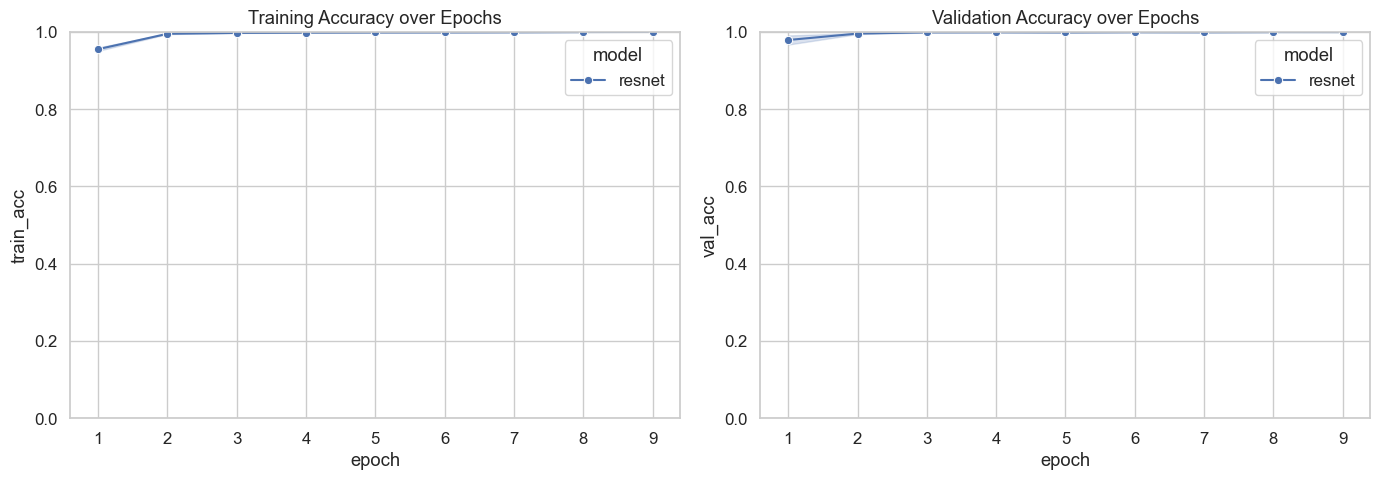

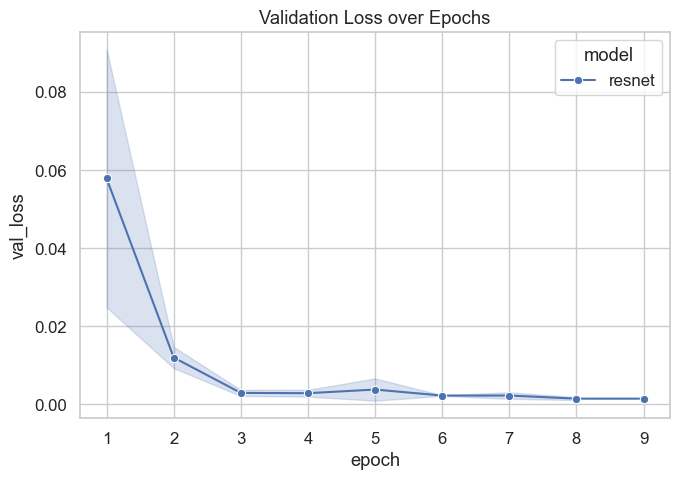

In [3]:
# 3. Accuracy/Loss over Epochs
if not train_df.empty:
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    sns.lineplot(data=train_df, x="epoch", y="train_acc", hue="model", marker="o", ax=ax[0])
    ax[0].set_title("Training Accuracy over Epochs"); ax[0].set_ylim(0, 1)
    sns.lineplot(data=train_df, x="epoch", y="val_acc", hue="model", marker="o", ax=ax[1])
    ax[1].set_title("Validation Accuracy over Epochs"); ax[1].set_ylim(0, 1)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,5))
    sns.lineplot(data=train_df, x="epoch", y="val_loss", hue="model", marker="o")
    plt.title("Validation Loss over Epochs"); plt.tight_layout(); plt.show()
else:
    print("No training logs found in models/saved/")

In [4]:
# 4. Load and Compare Final Evaluation Metrics
metric_files = sorted(results_dir.glob("metrics_summary_*.csv"))
eval_data = []
for file in metric_files:
    df = pd.read_csv(file)
    df["model"] = file.stem.replace("metrics_summary_", "")
    eval_data.append(df)

eval_df = pd.concat(eval_data, ignore_index=True) if eval_data else pd.DataFrame()
eval_df

,accuracy,precision,recall,f1,model
0,0.999286,0.998573,1.0,0.999286,resnet18


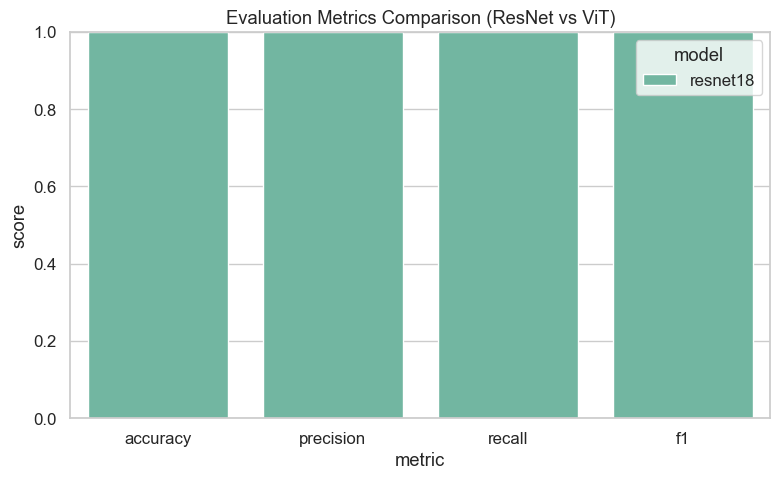

In [5]:
# 5. Evaluation Metrics Comparison
if not eval_df.empty:
    melted = eval_df.melt(id_vars=["model"], var_name="metric", value_name="score")
    plt.figure(figsize=(8,5))
    sns.barplot(data=melted, x="metric", y="score", hue="model", palette="Set2")
    plt.title("Evaluation Metrics Comparison (ResNet vs ViT)")
    plt.ylim(0, 1)
    plt.tight_layout(); plt.show()
else:
    print("No evaluation metrics found in results/")

In [6]:
# 6. Cross-Generator Generalization Analysis
cross_files = sorted(results_dir.glob("cross_generator_results_*.csv"))
cross_dfs = []
for file in cross_files:
    df = pd.read_csv(file)
    df["model"] = file.stem.replace("cross_generator_results_", "")
    cross_dfs.append(df)

cross_df = pd.concat(cross_dfs, ignore_index=True) if cross_dfs else pd.DataFrame()
cross_df

,accuracy,precision,recall,f1,test_generator,model
0,0.999,0.998004,1.000,0.999001,sdv5,resnet18
1,1.000,1.000000,1.000,1.000000,glide,resnet18
2,1.000,1.000000,1.000,1.000000,vqdm,resnet18
3,0.998,1.000000,0.996,0.997996,midjourney,resnet18
4,1.000,1.000000,1.000,1.000000,adm,resnet18
5,1.000,1.000000,1.000,1.000000,biggan,resnet18
6,1.000,1.000000,1.000,1.000000,wukong,resnet18


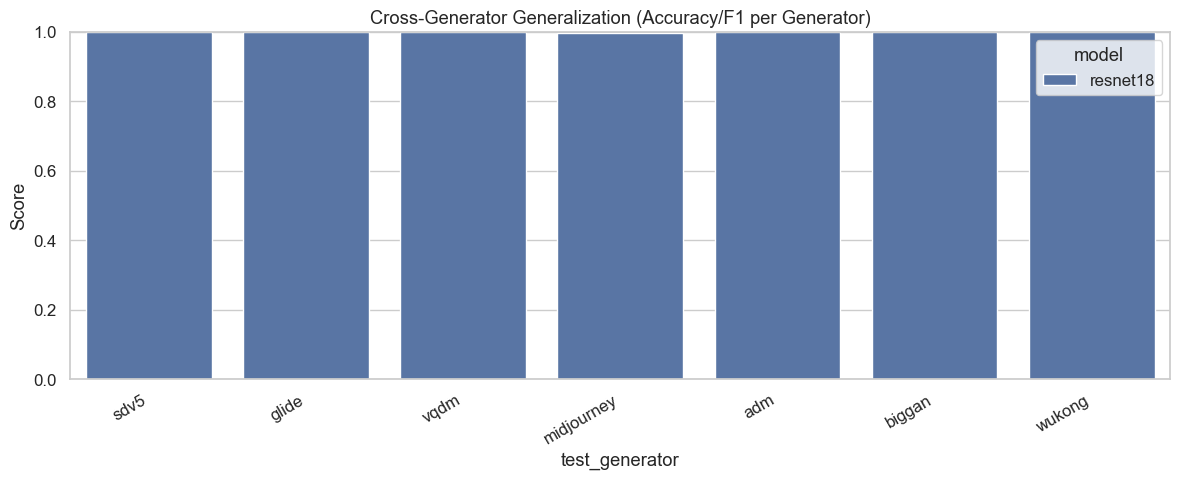

In [7]:
# 7. Cross-Generator Bars (Accuracy/F1)
if not cross_df.empty:
    melted = cross_df.melt(id_vars=["model","test_generator"], value_vars=["accuracy","f1"], var_name="metric", value_name="value")
    plt.figure(figsize=(12,5))
    sns.barplot(data=melted, x="test_generator", y="value", hue="model")
    plt.title("Cross-Generator Generalization (Accuracy/F1 per Generator)")
    plt.ylabel("Score"); plt.ylim(0, 1); plt.xticks(rotation=30, ha="right")
    plt.tight_layout(); plt.show()
else:
    print("No cross-generator results found in results/")

confusion_matrix_resnet18.png


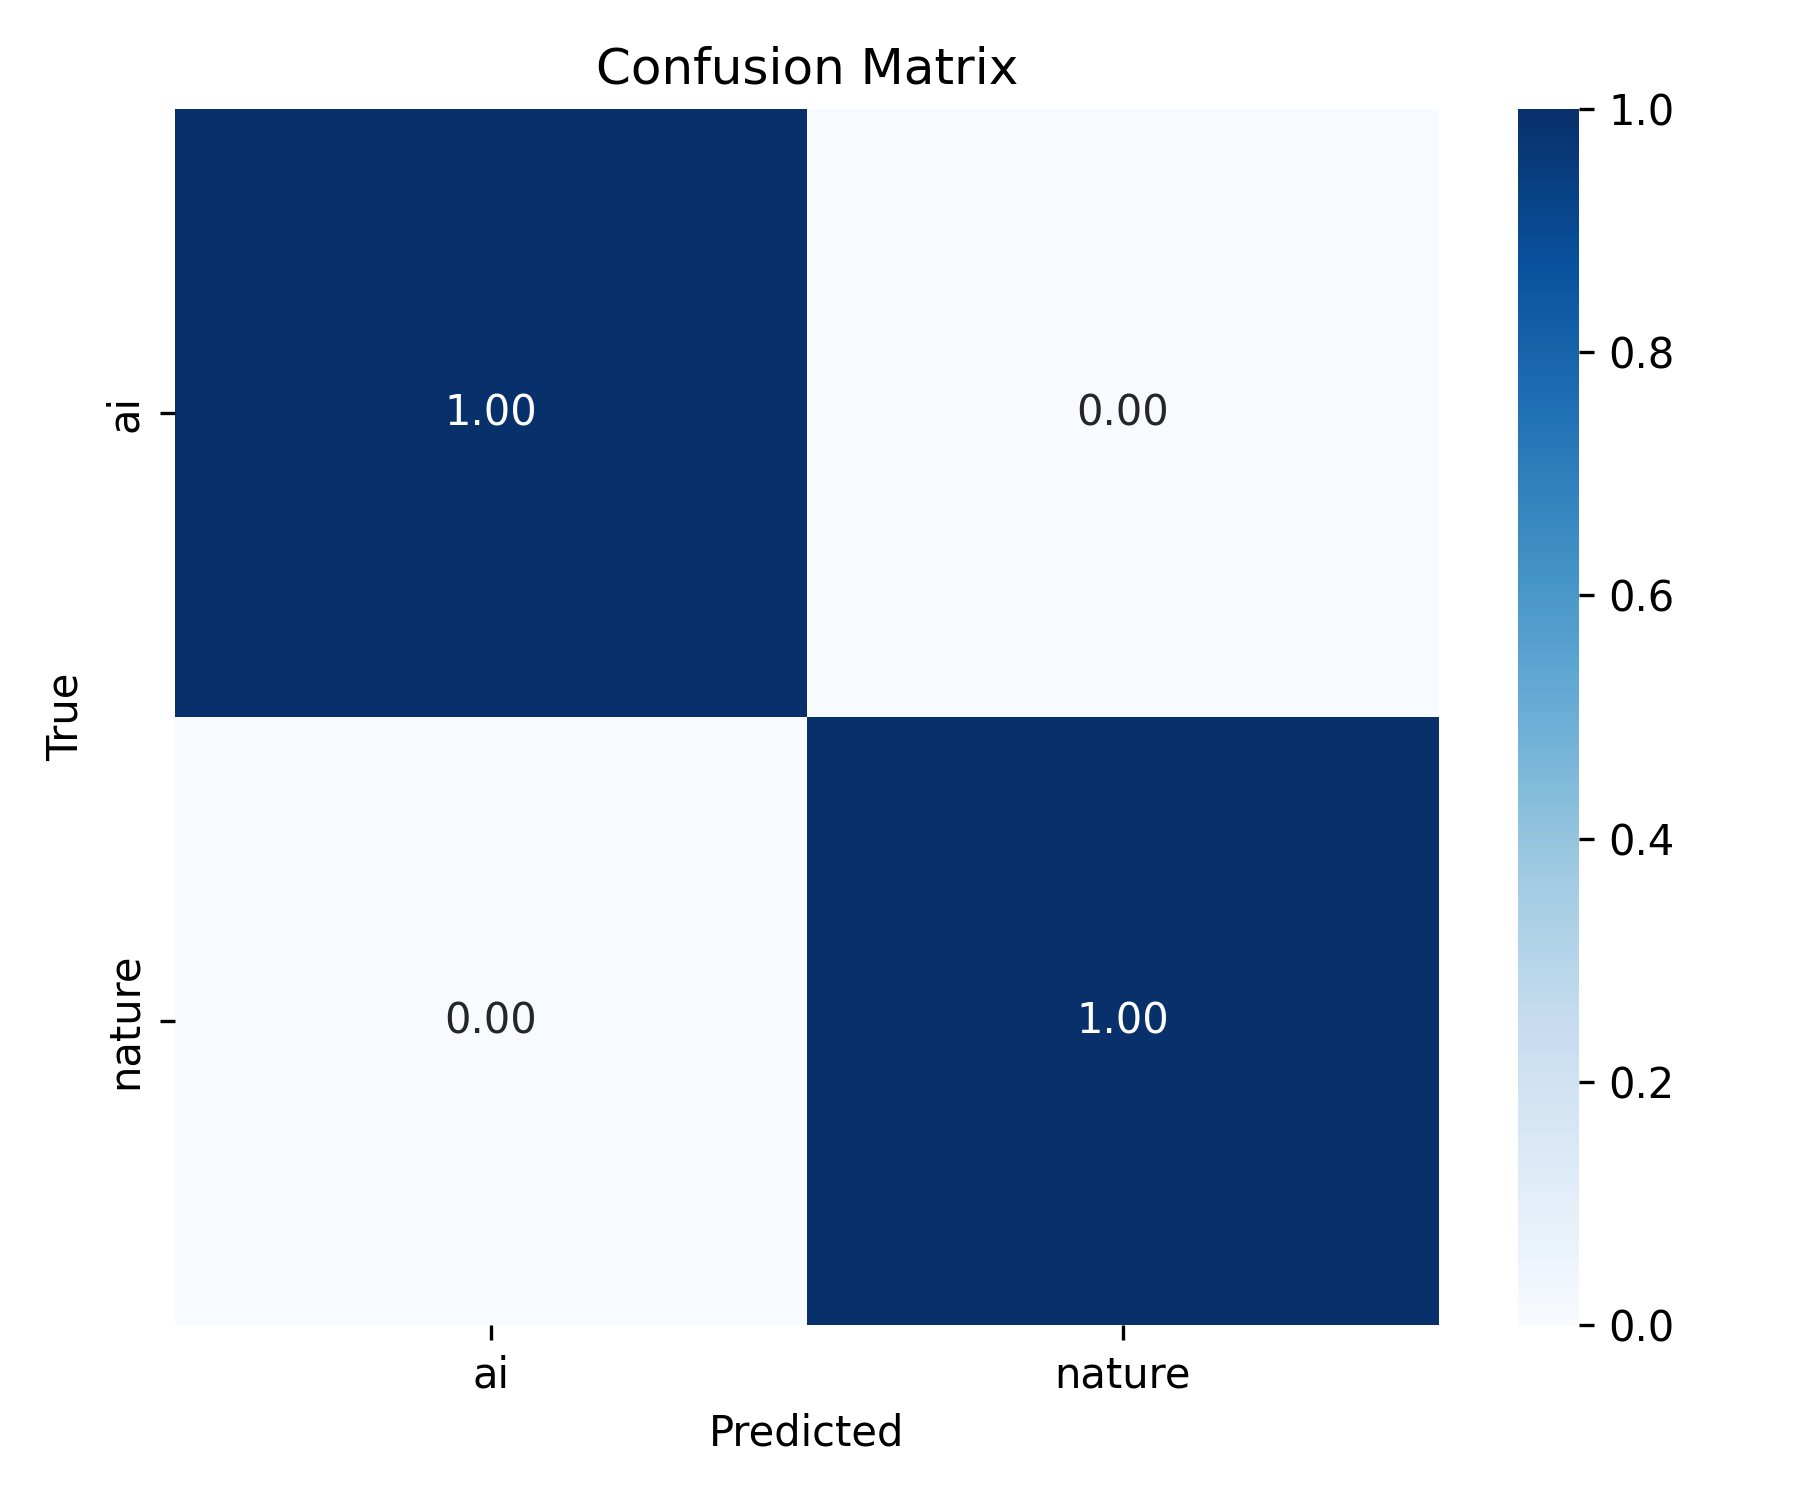

confusion_matrix_resnet18_adm.png


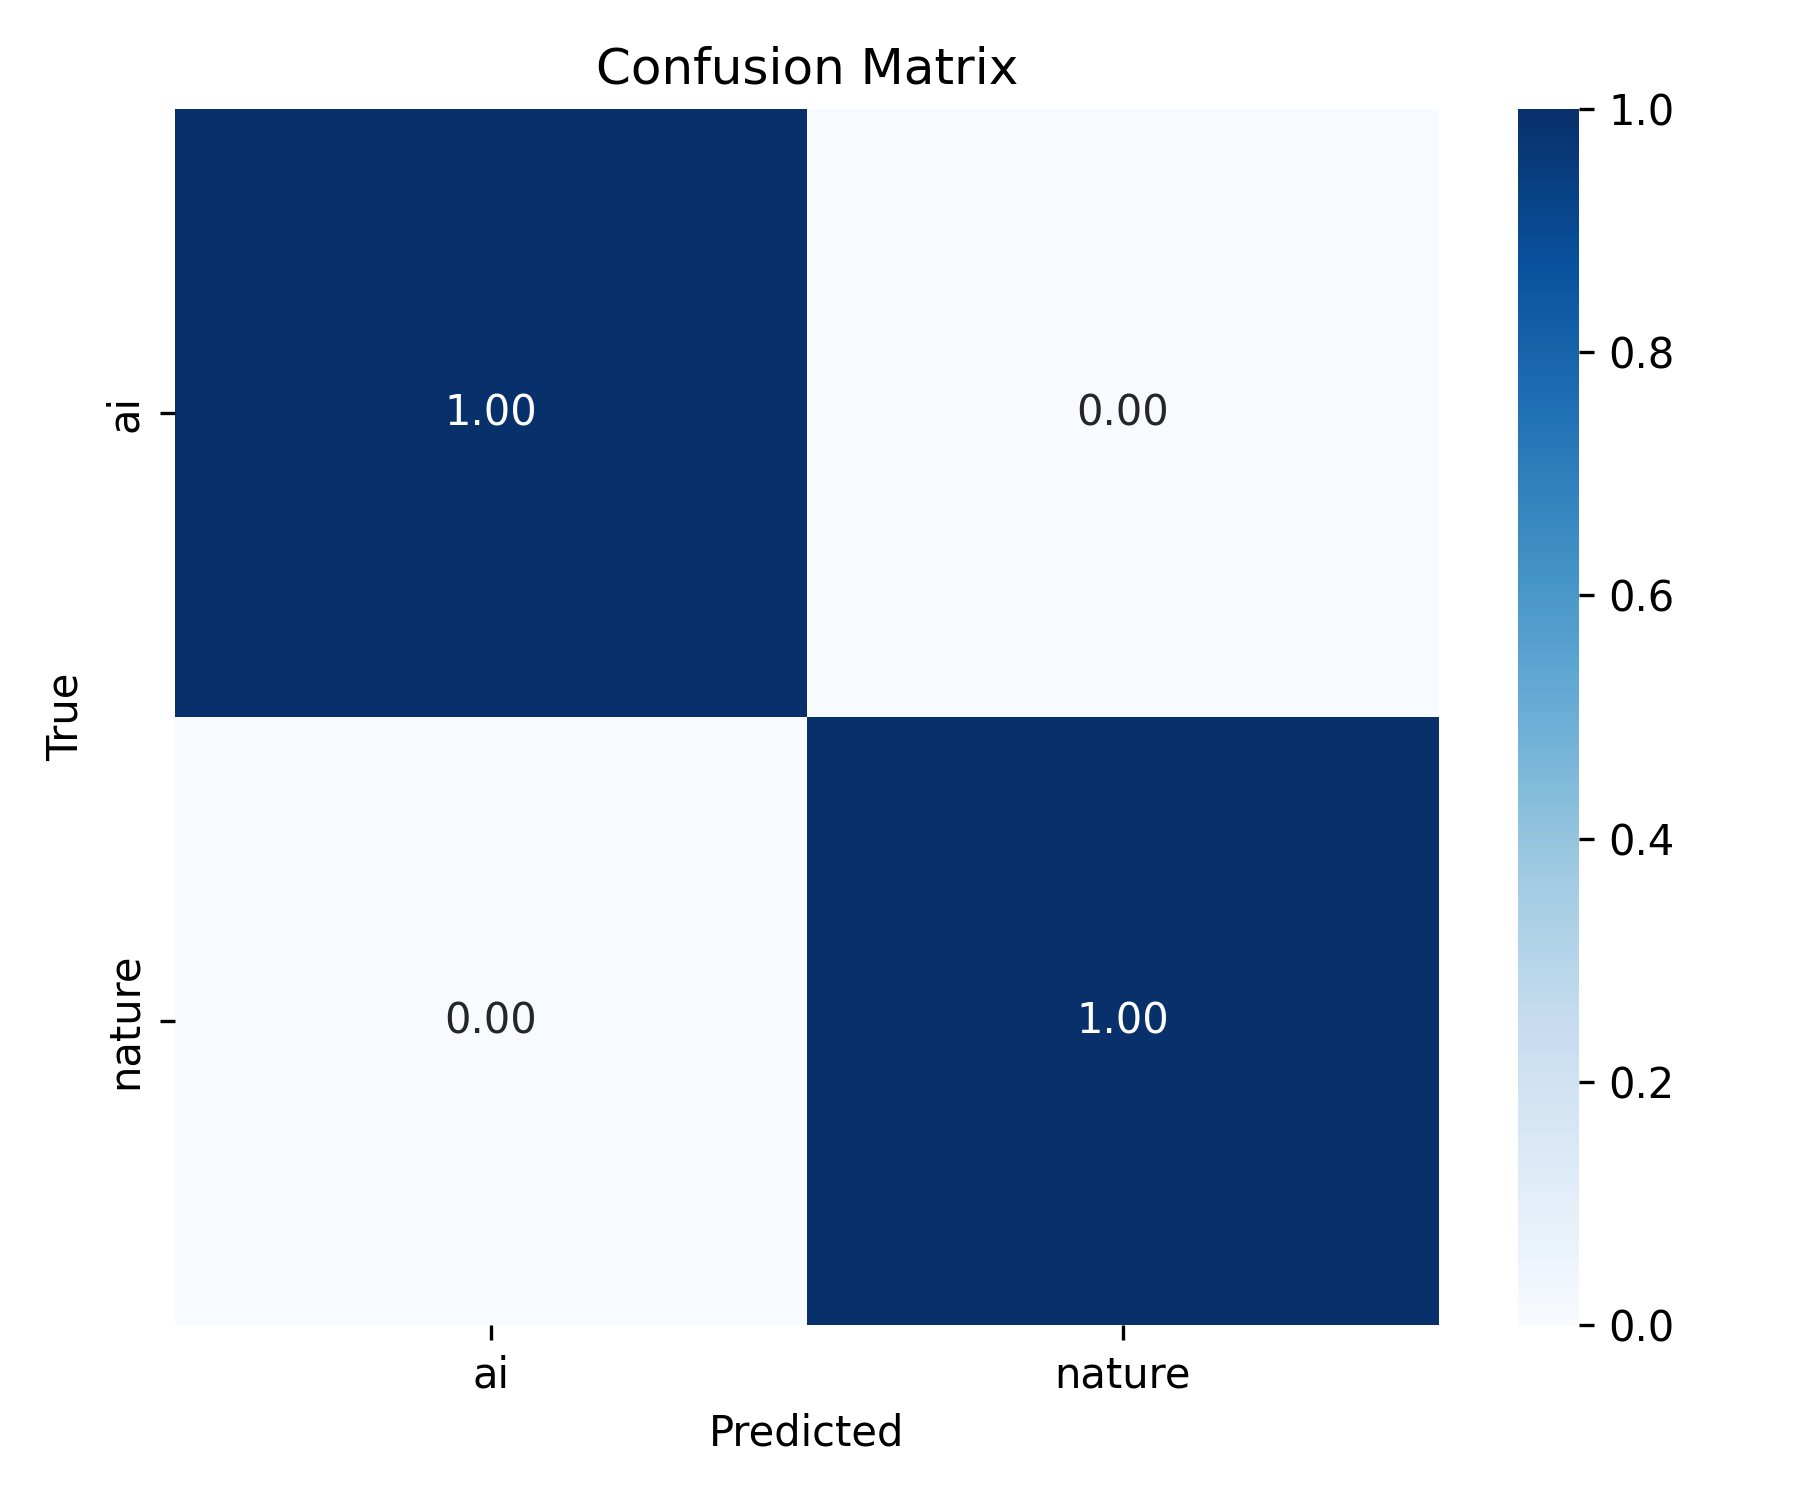

confusion_matrix_resnet18_adm_raw.png


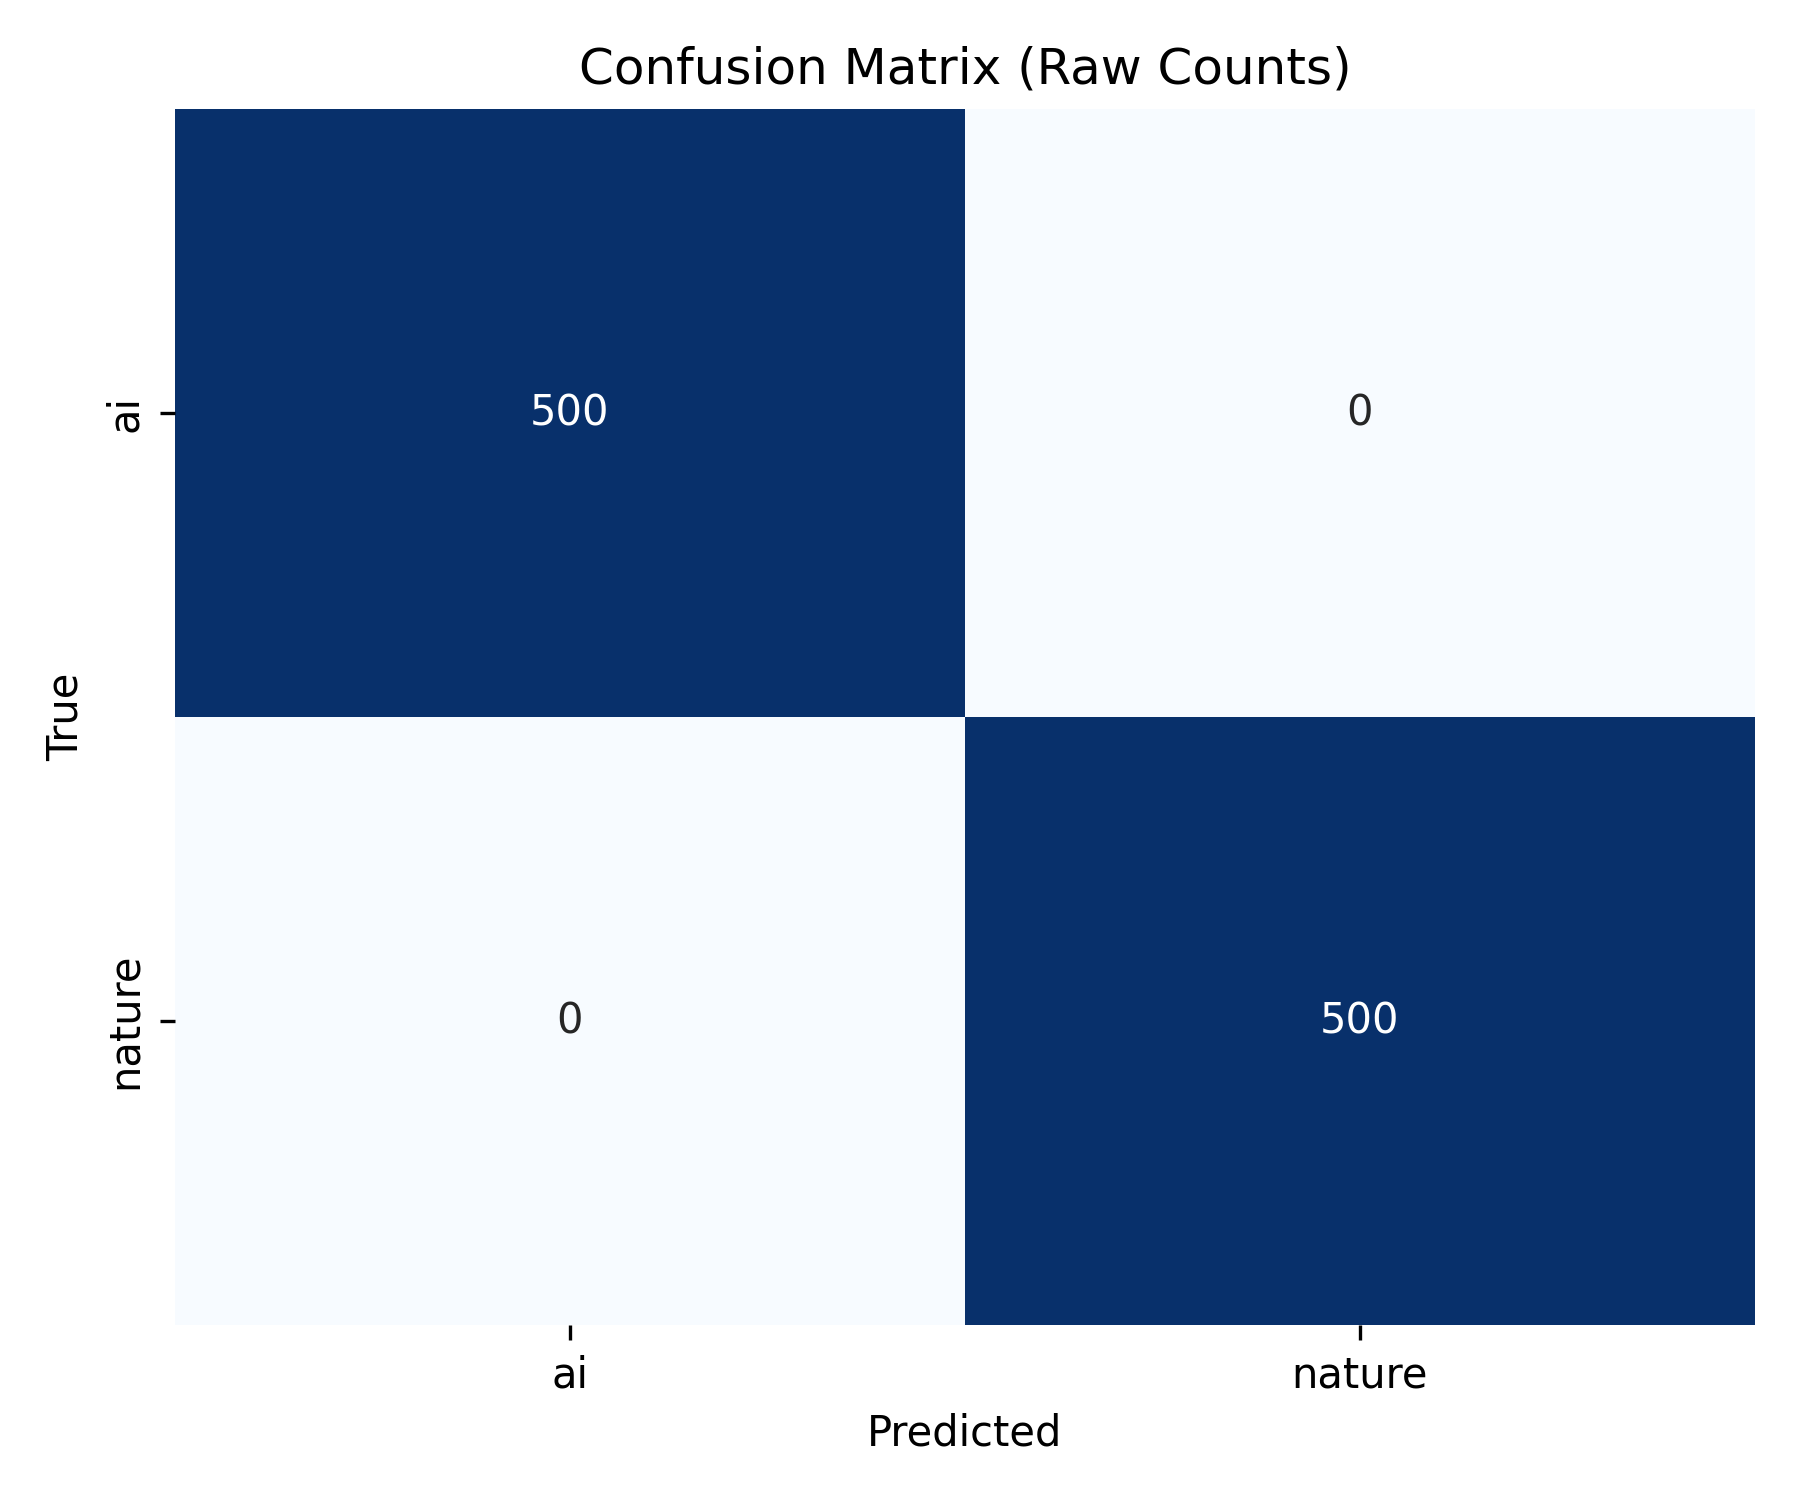

confusion_matrix_resnet18_biggan.png


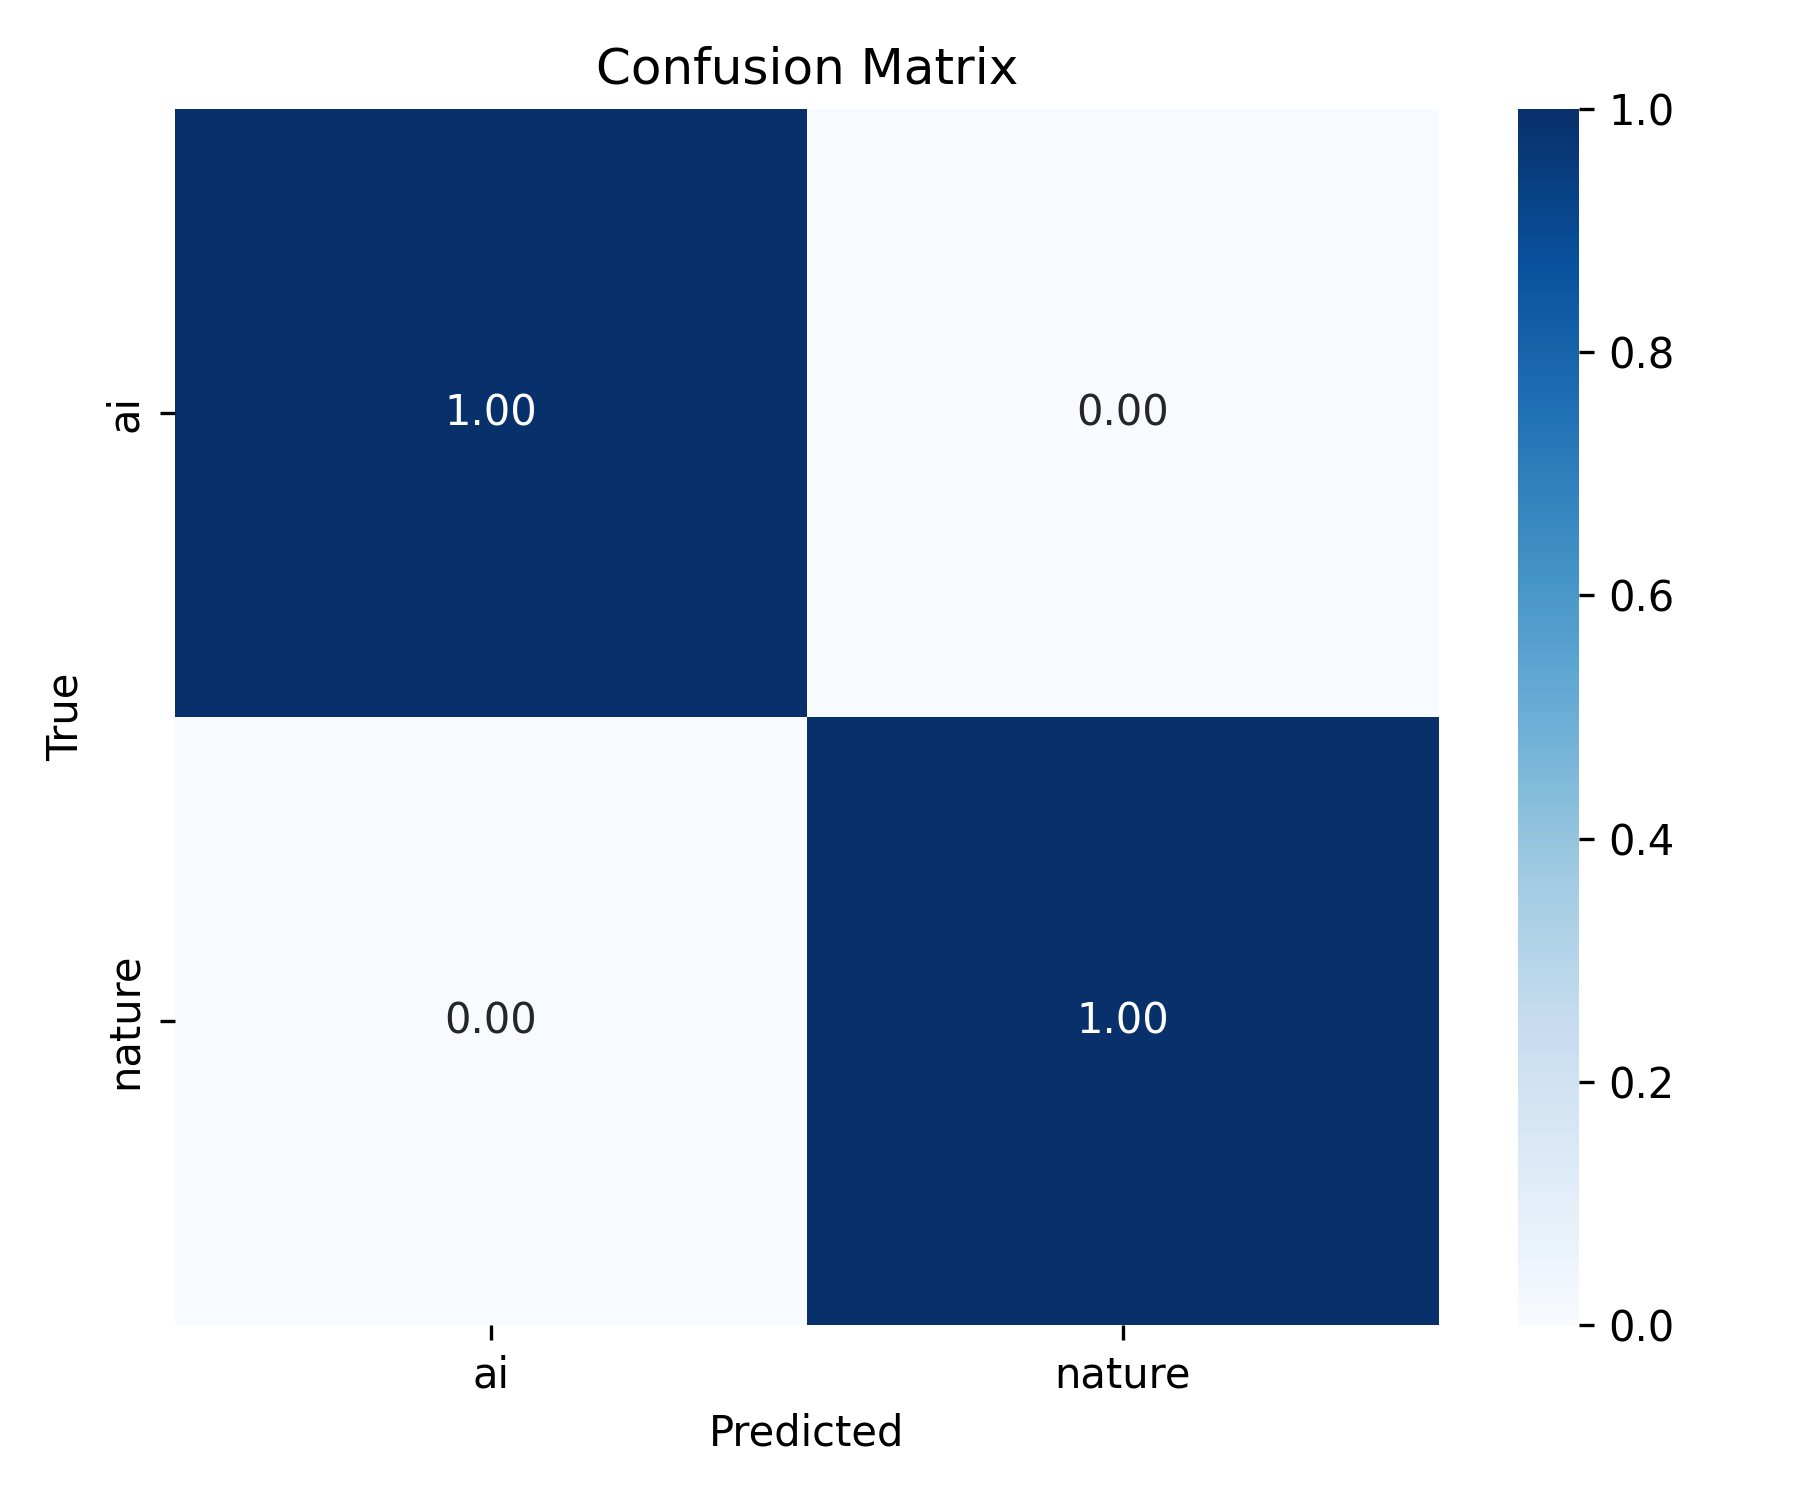

confusion_matrix_resnet18_biggan_raw.png


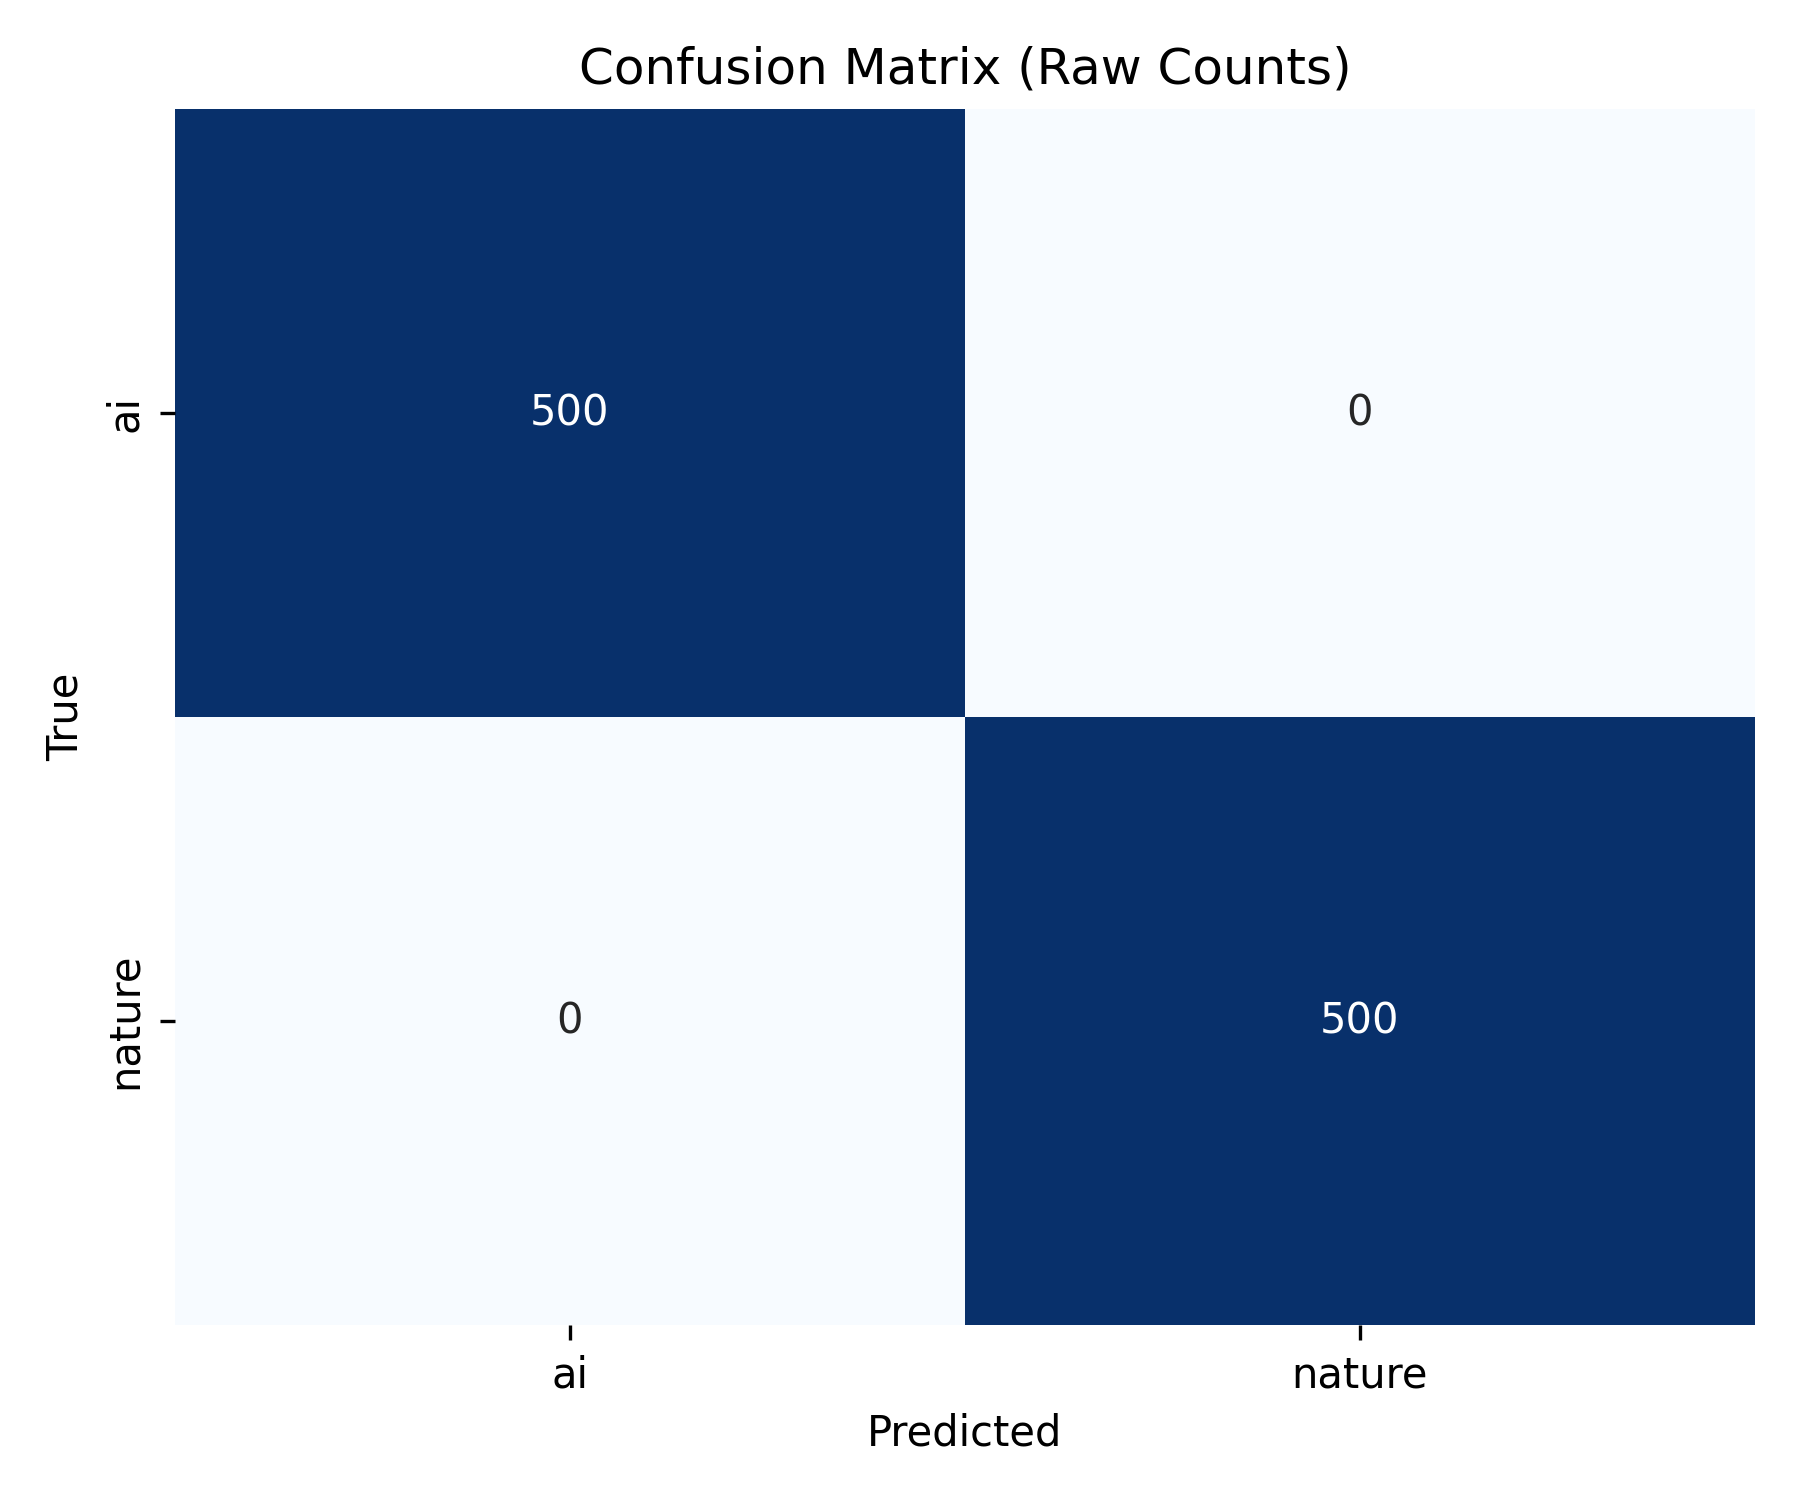

confusion_matrix_resnet18_glide.png


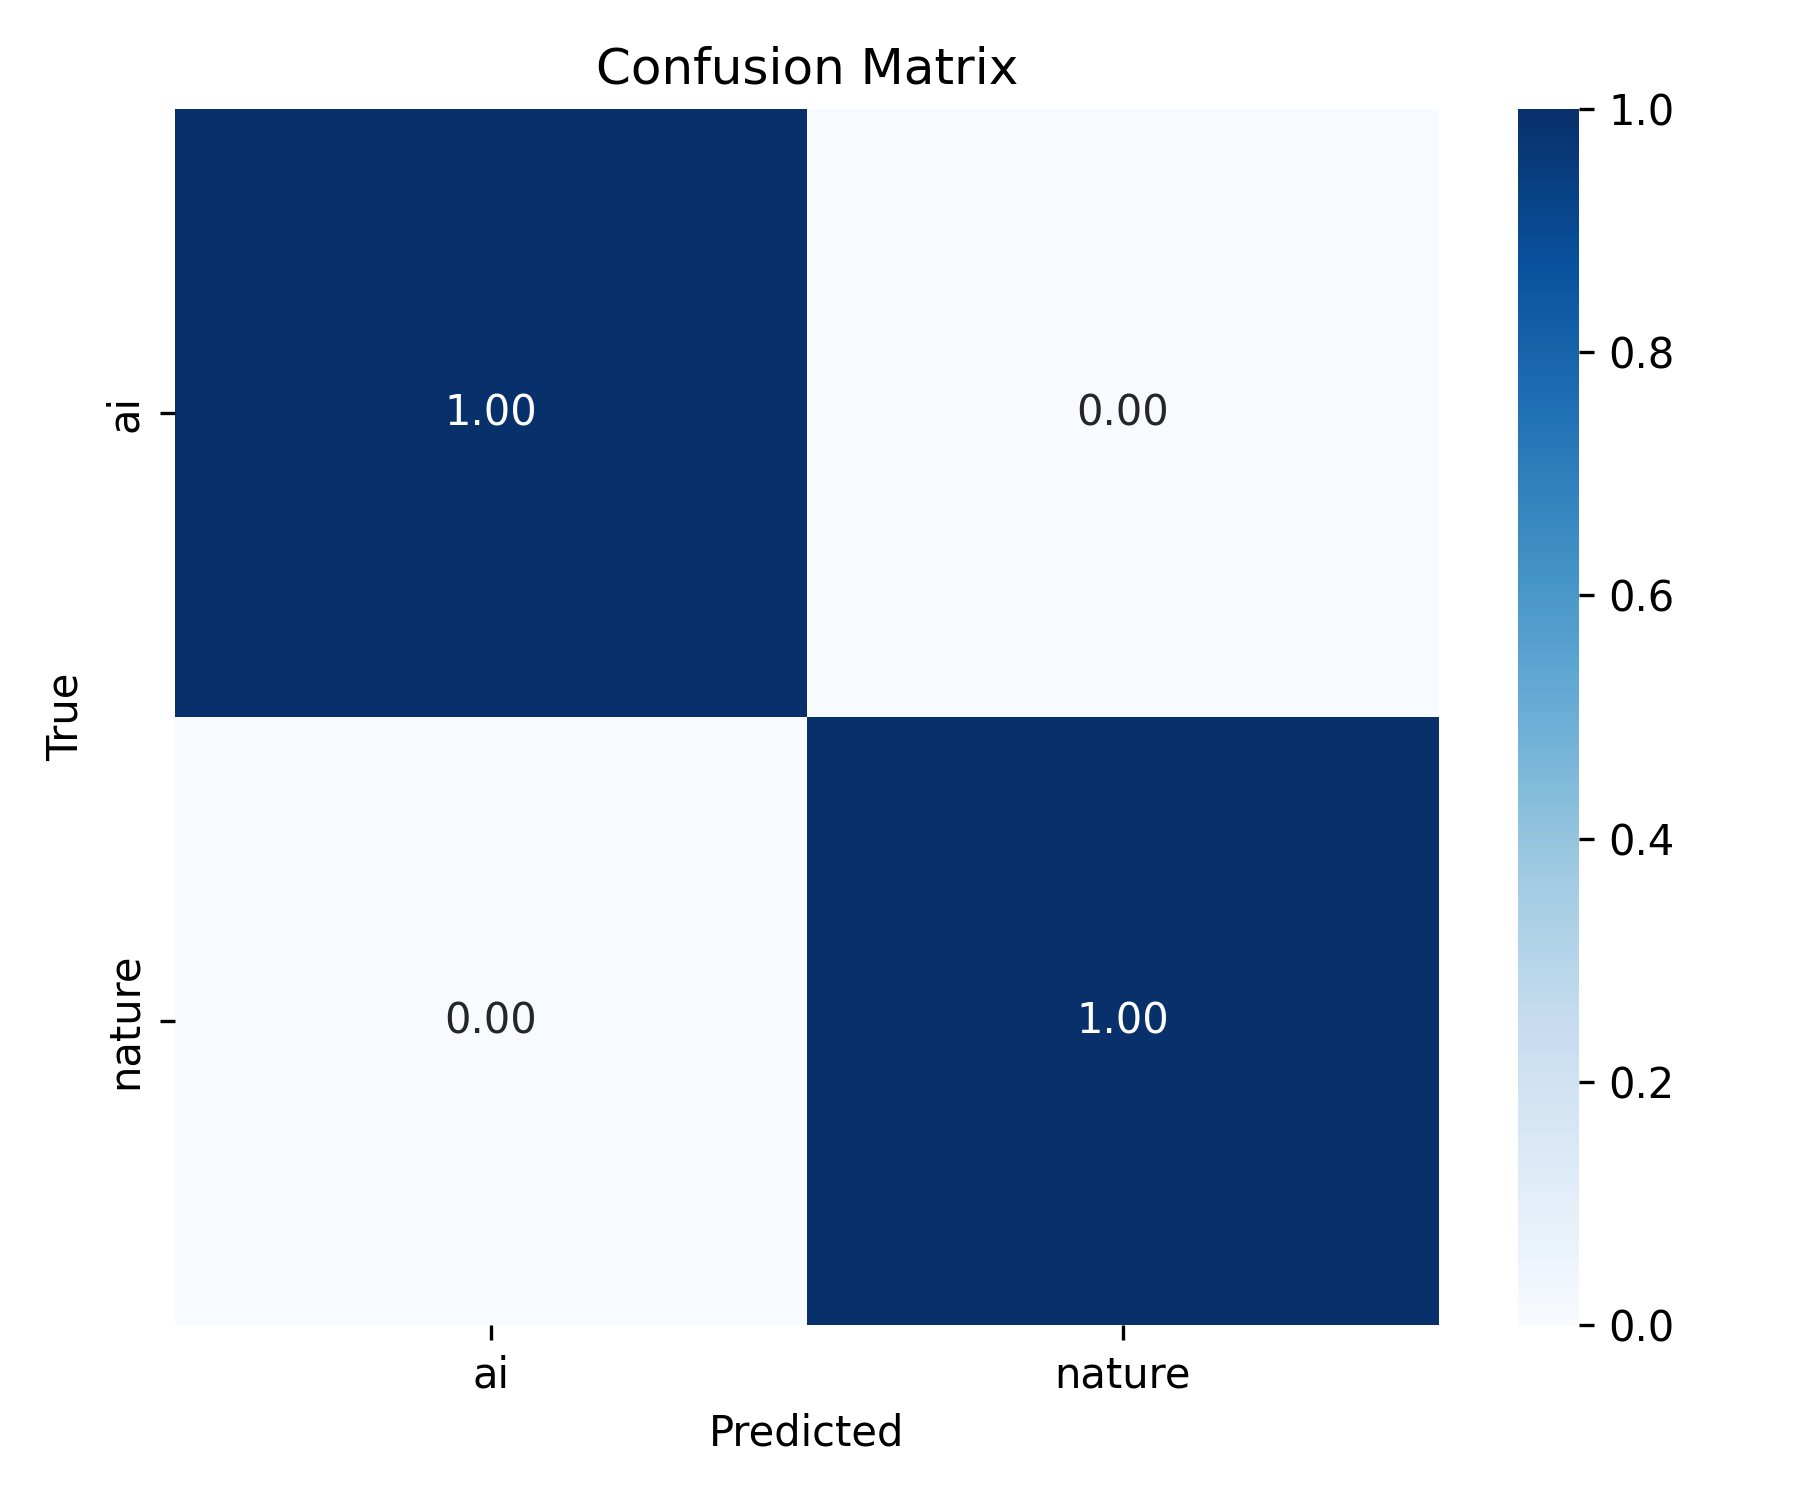

confusion_matrix_resnet18_glide_raw.png


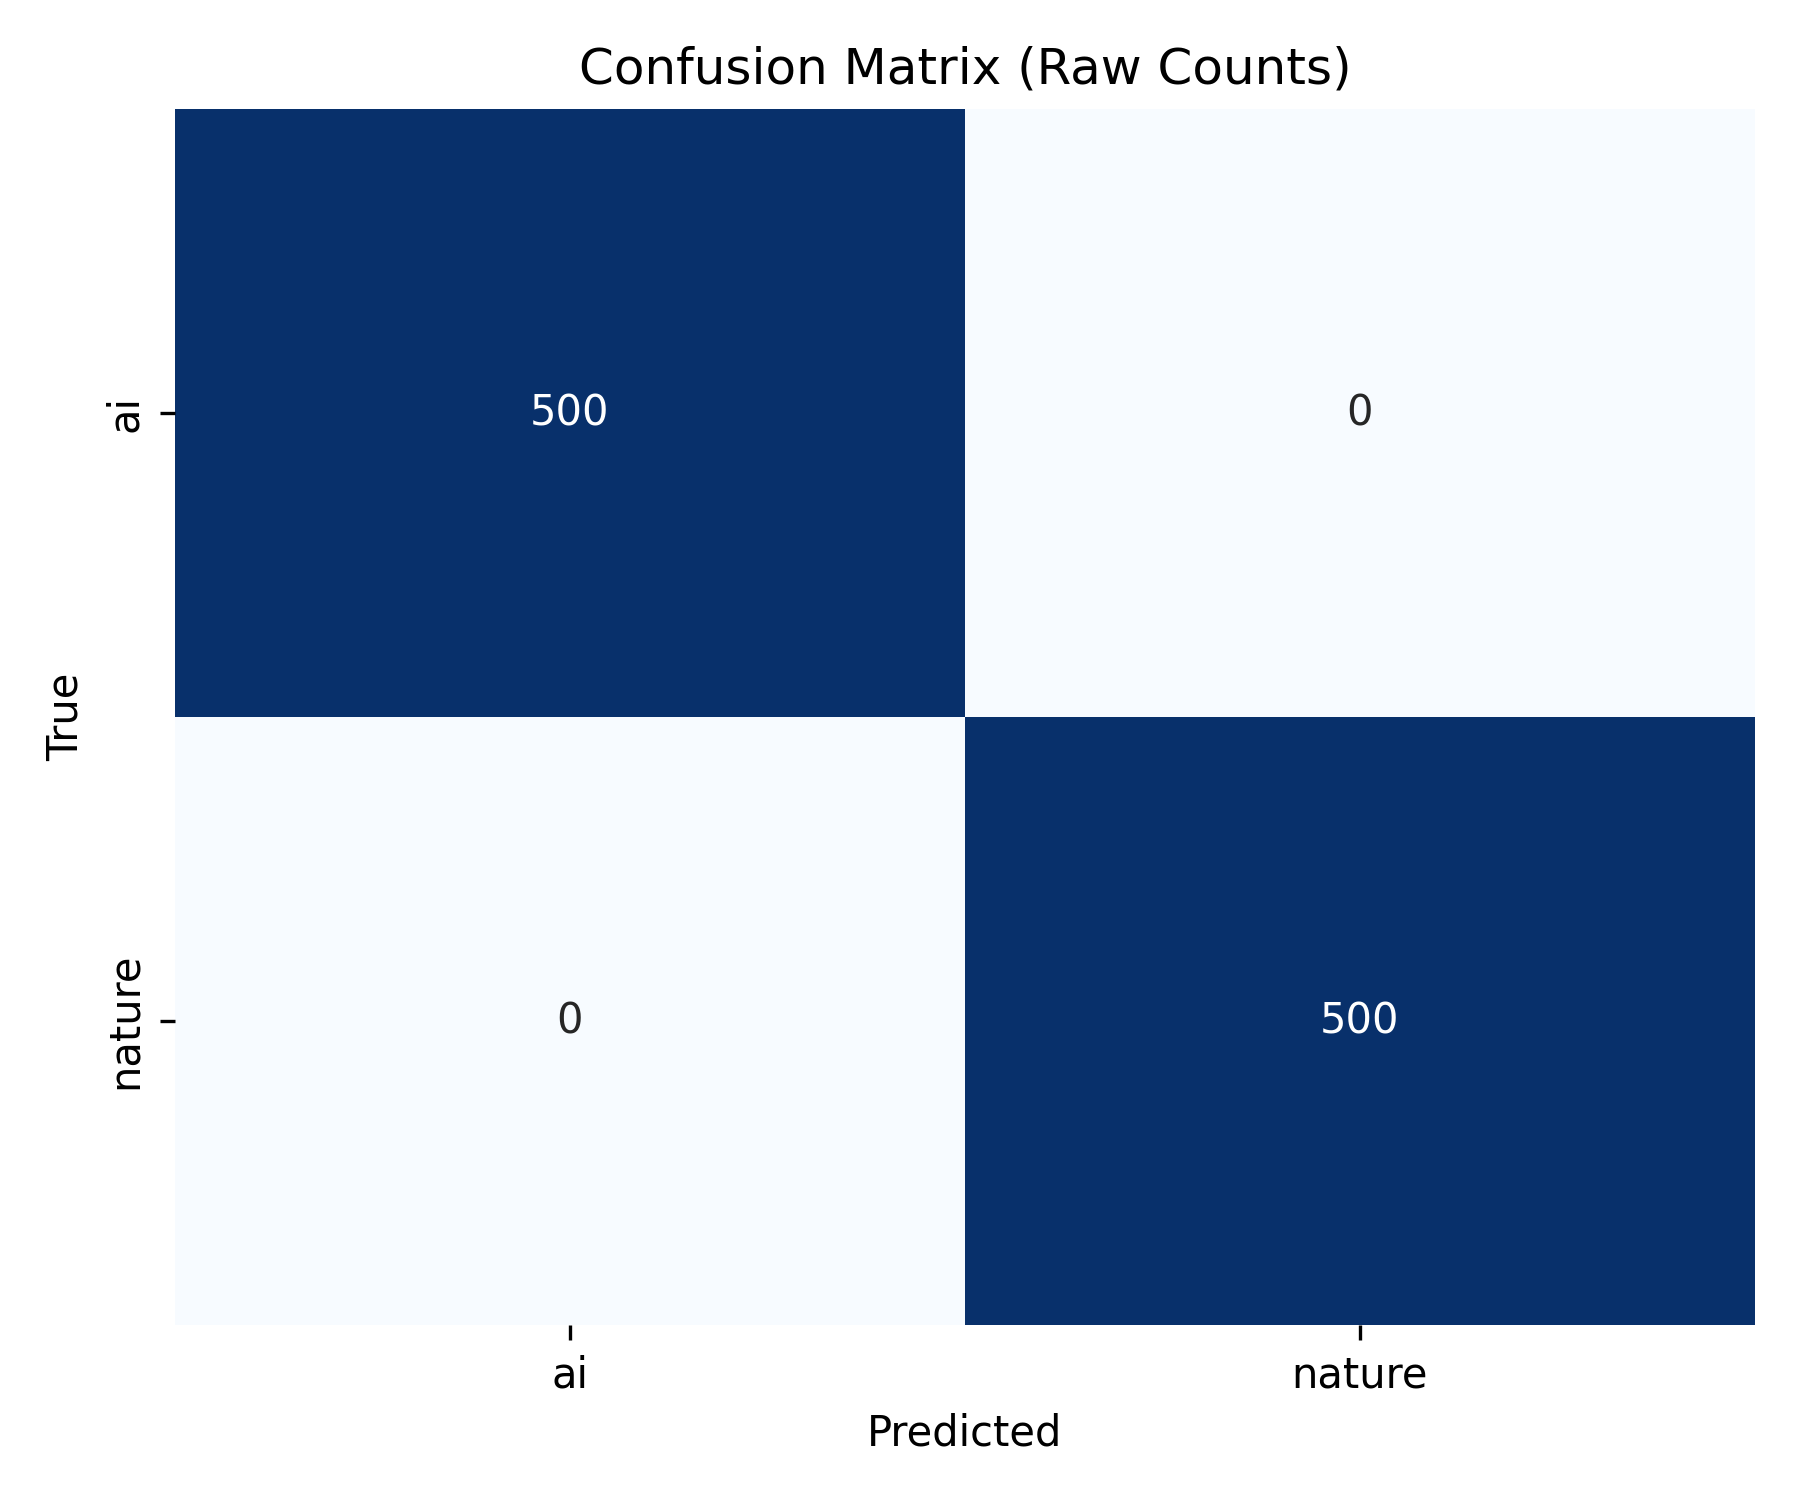

confusion_matrix_resnet18_midjourney.png


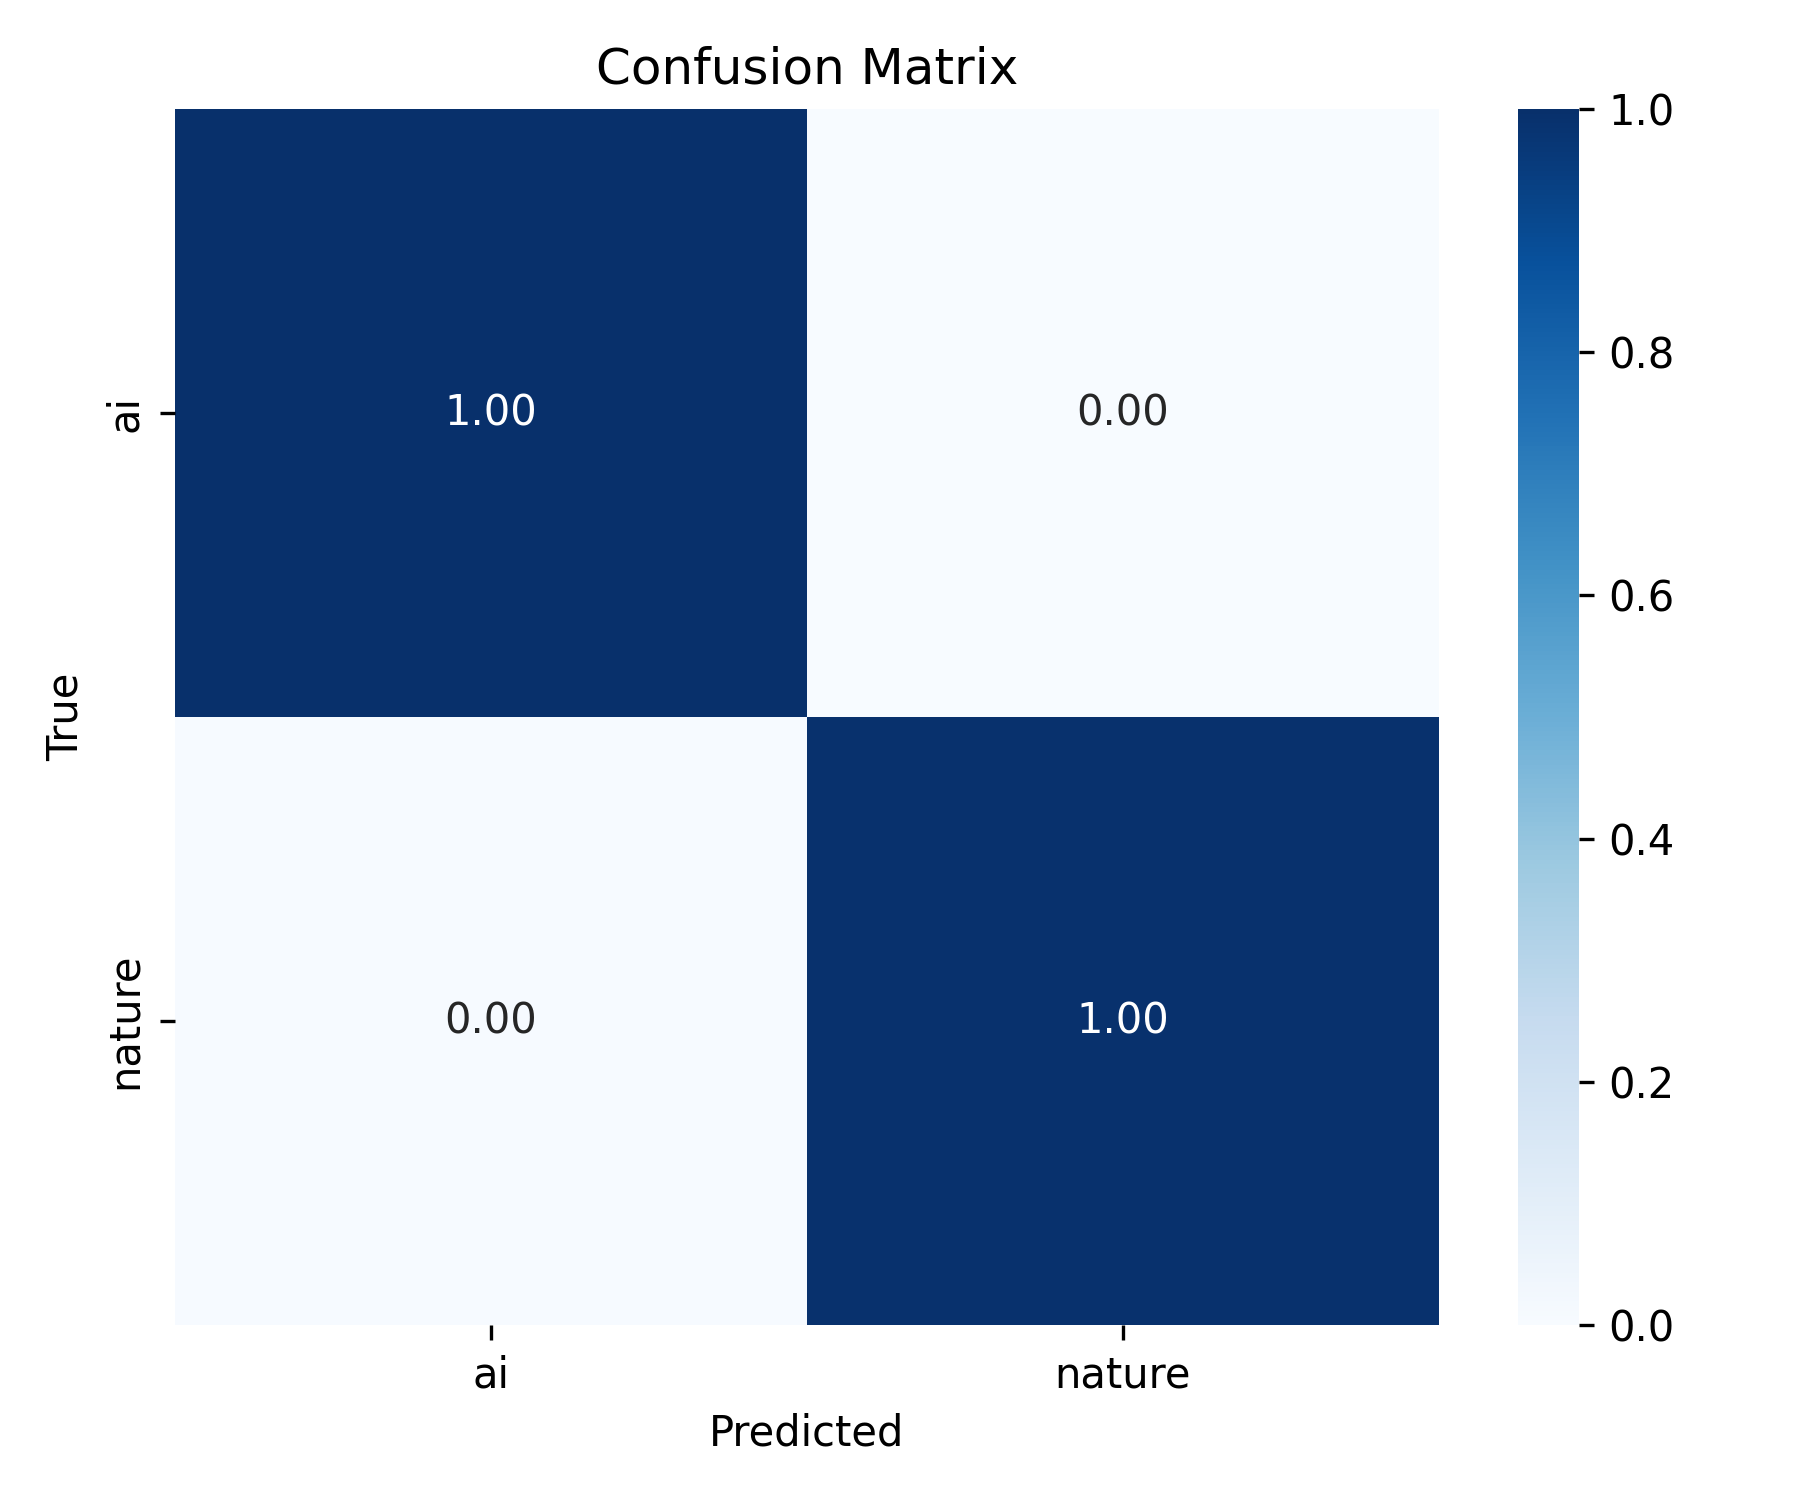

confusion_matrix_resnet18_midjourney_raw.png


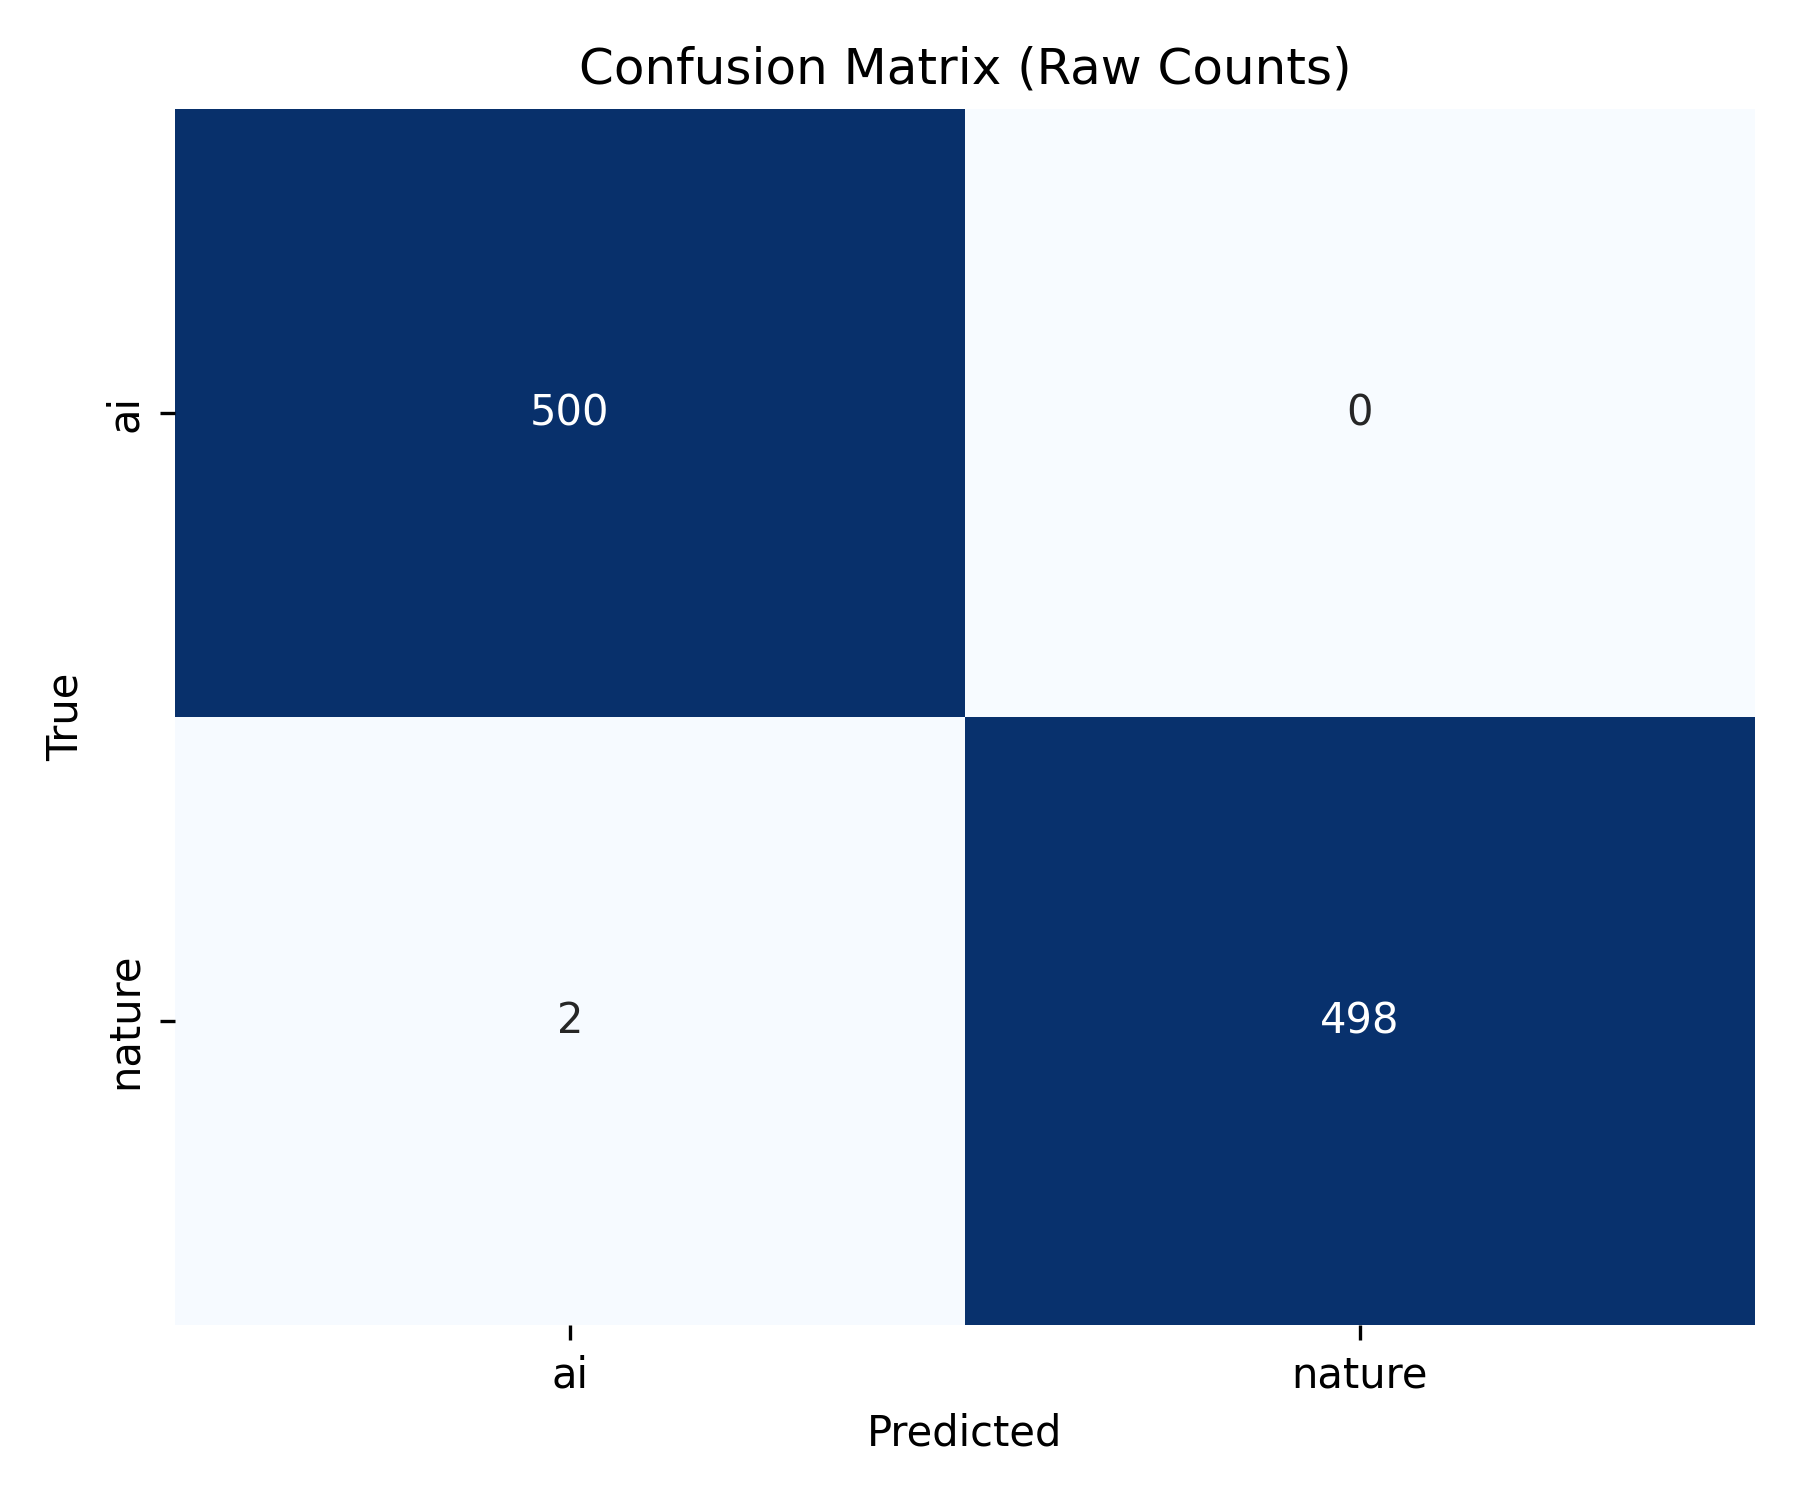

confusion_matrix_resnet18_raw.png


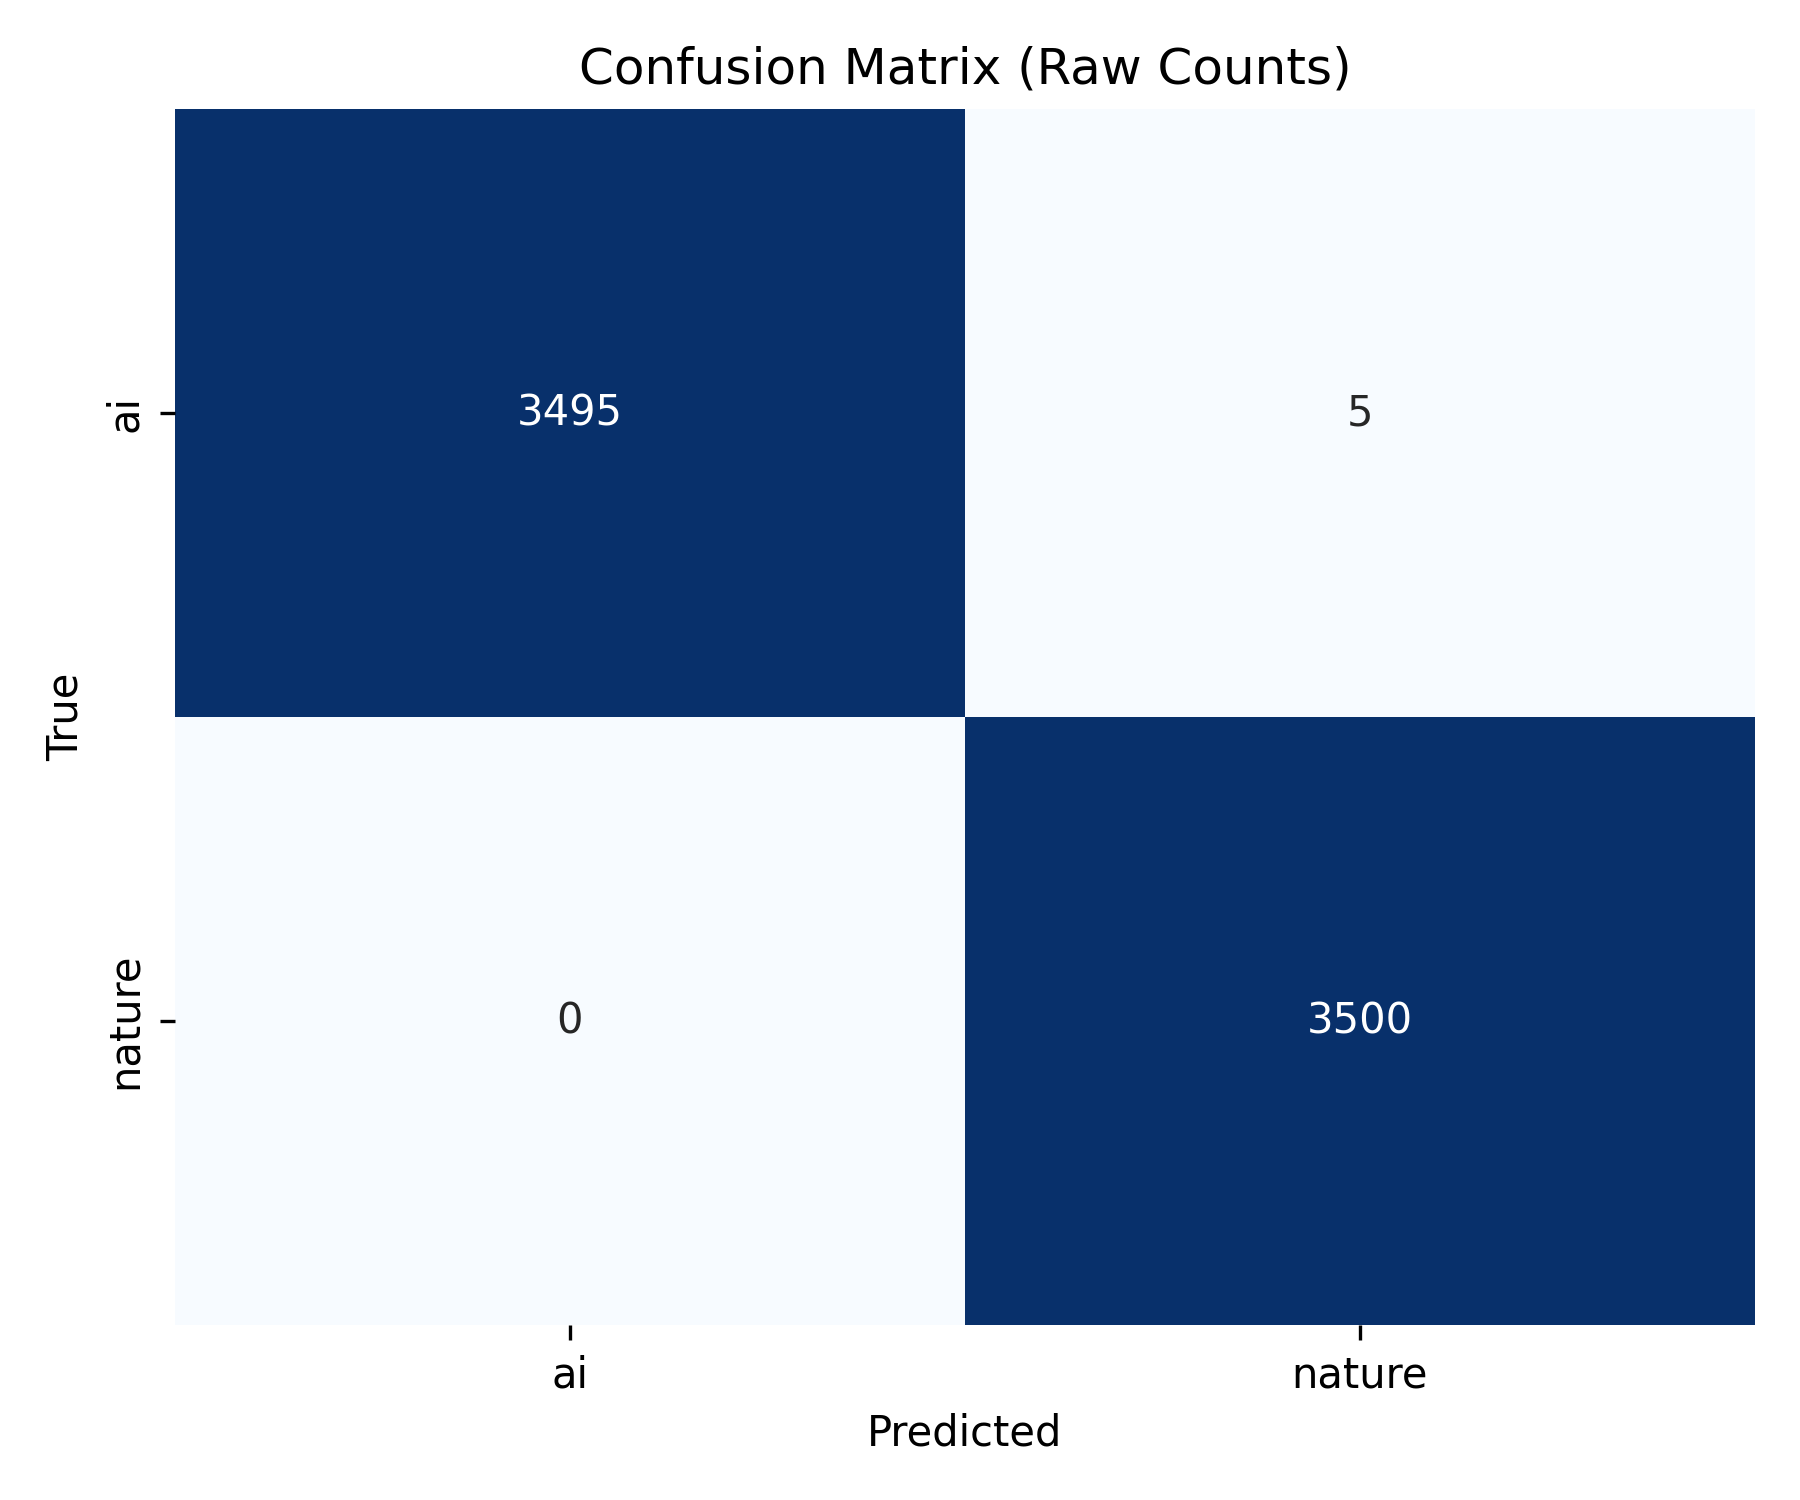

confusion_matrix_resnet18_sdv5.png


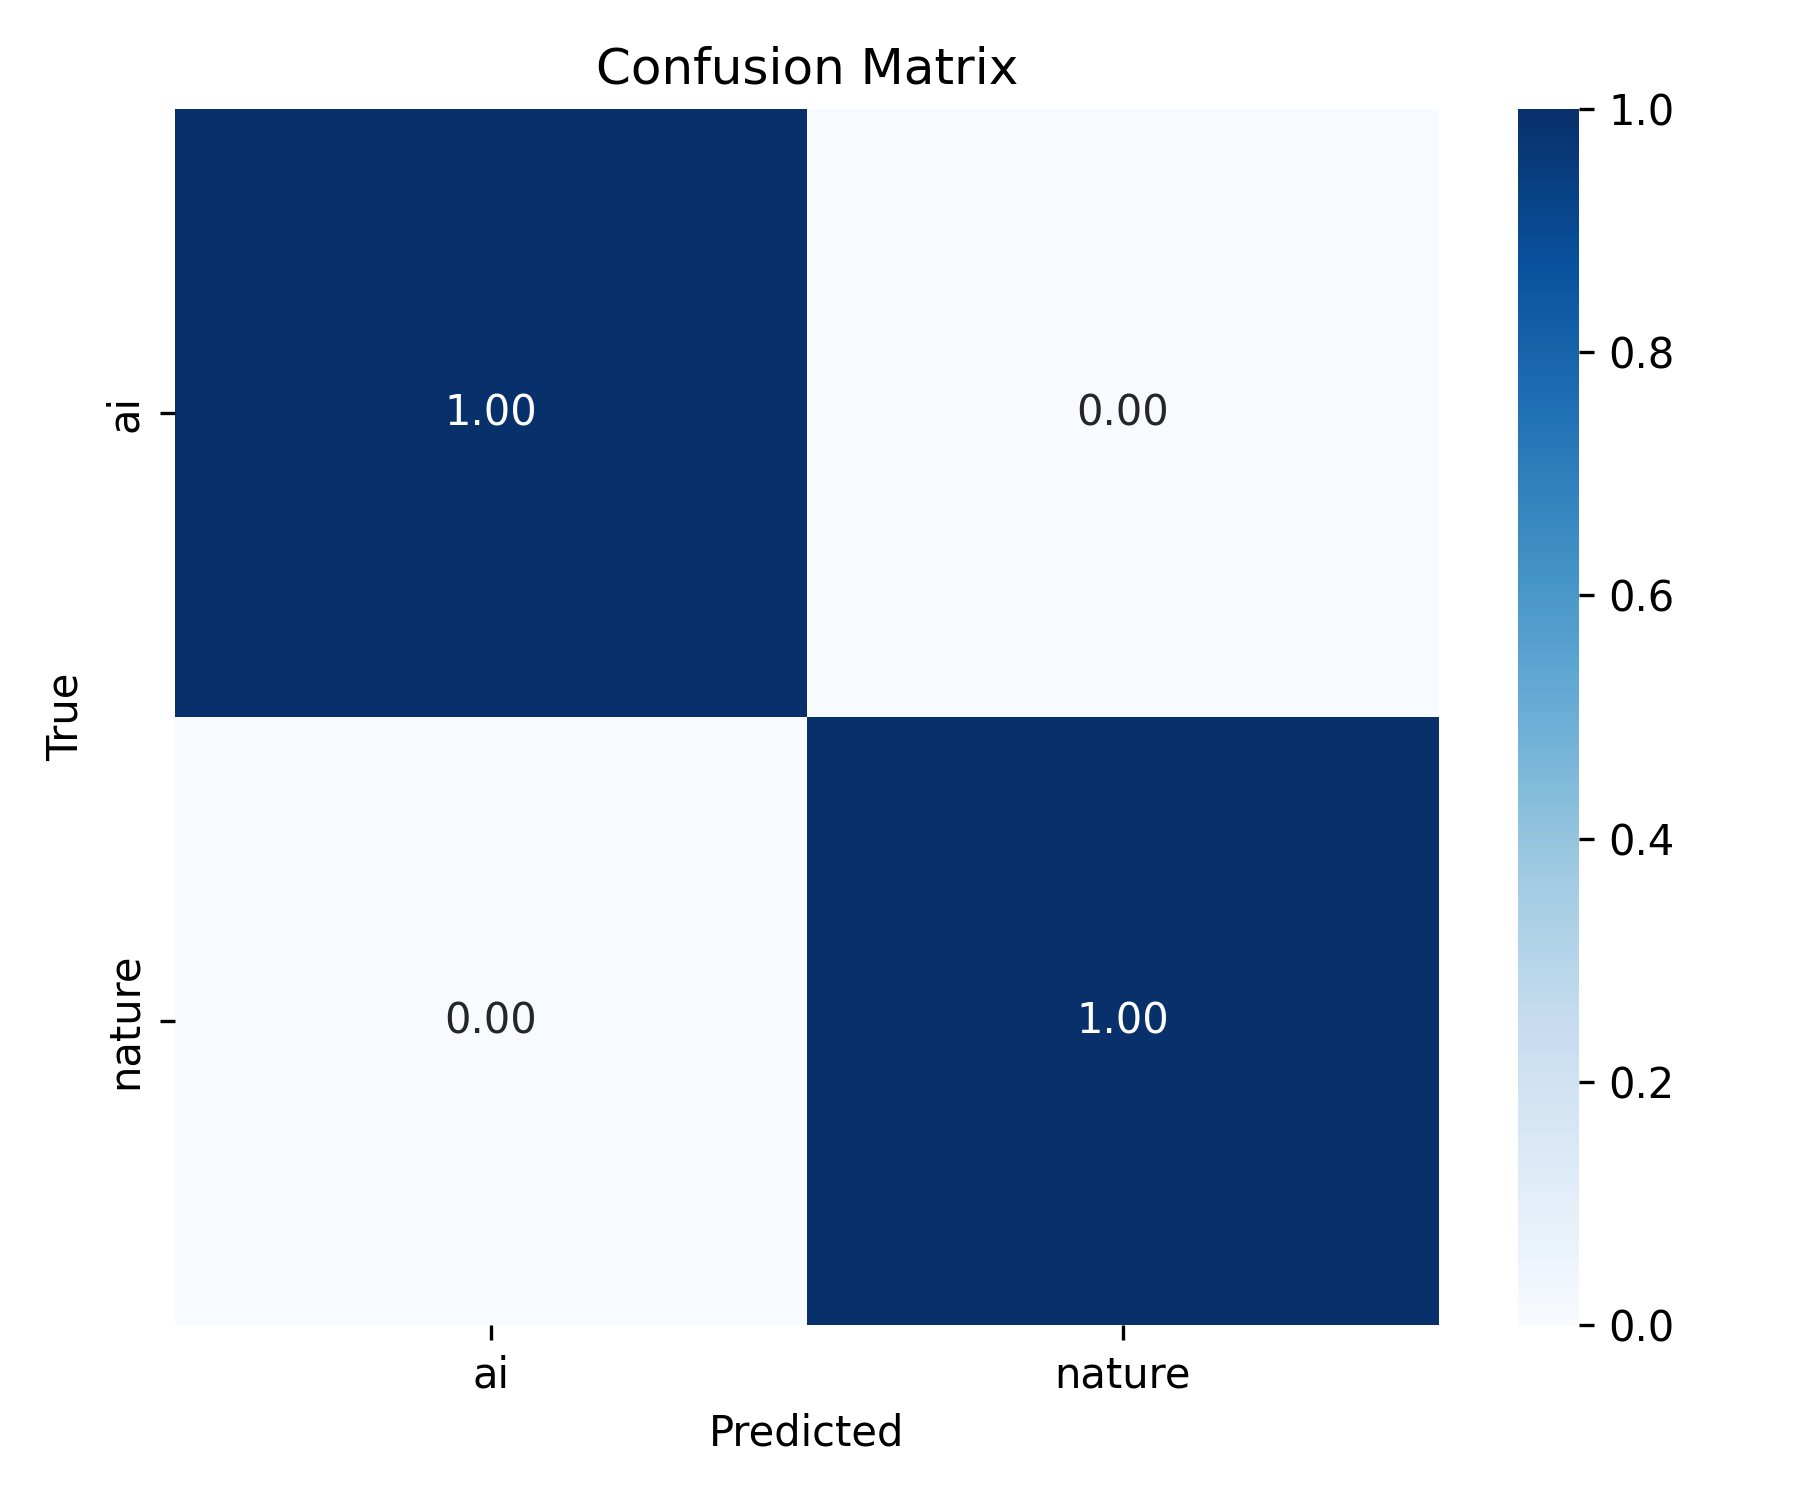

confusion_matrix_resnet18_sdv5_raw.png


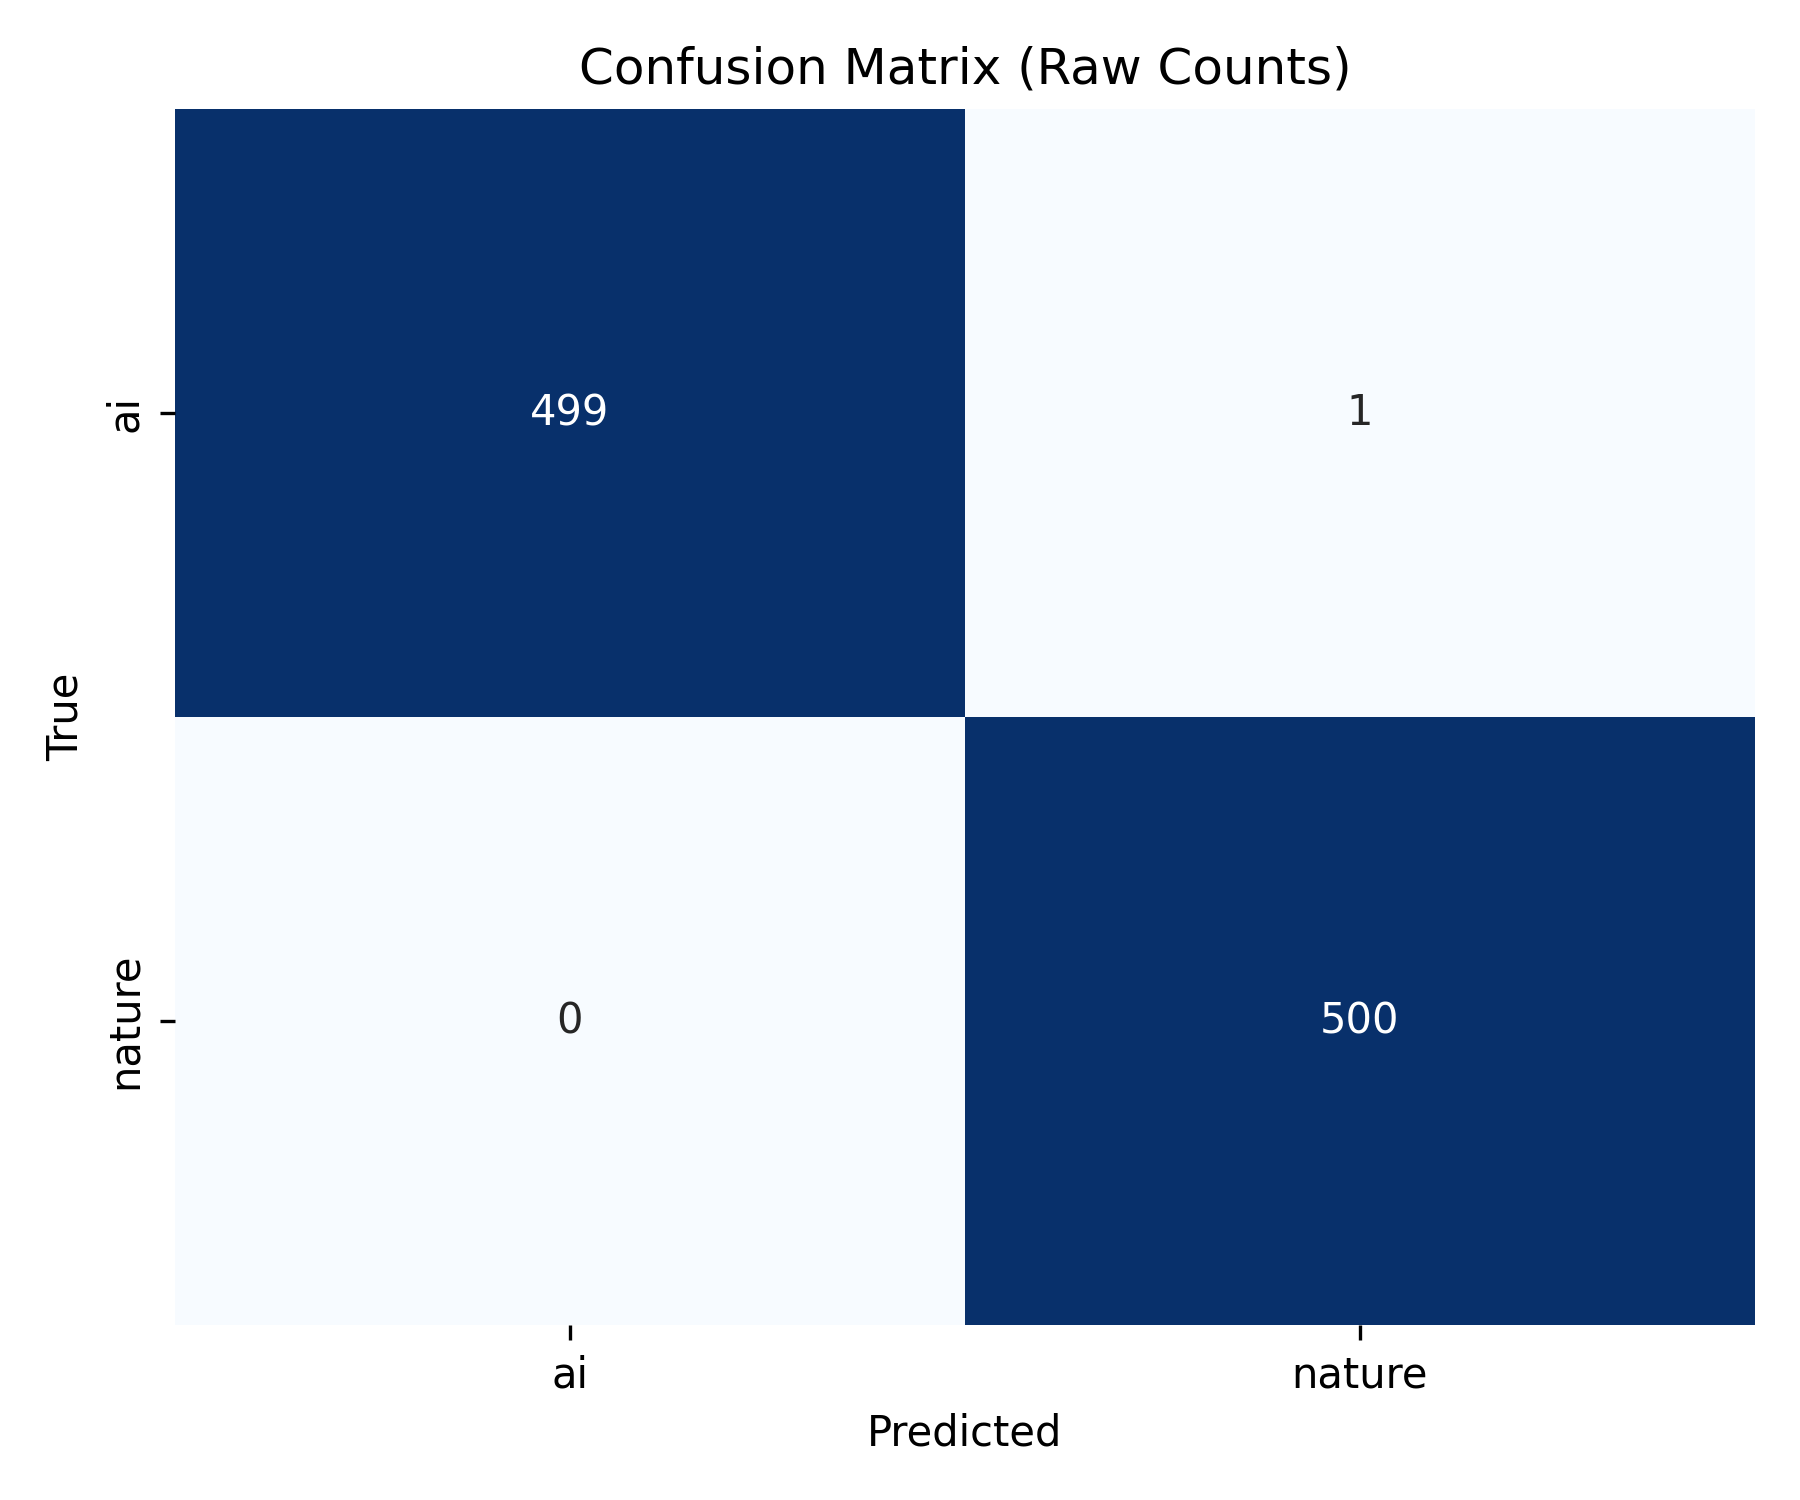

confusion_matrix_resnet18_vqdm.png


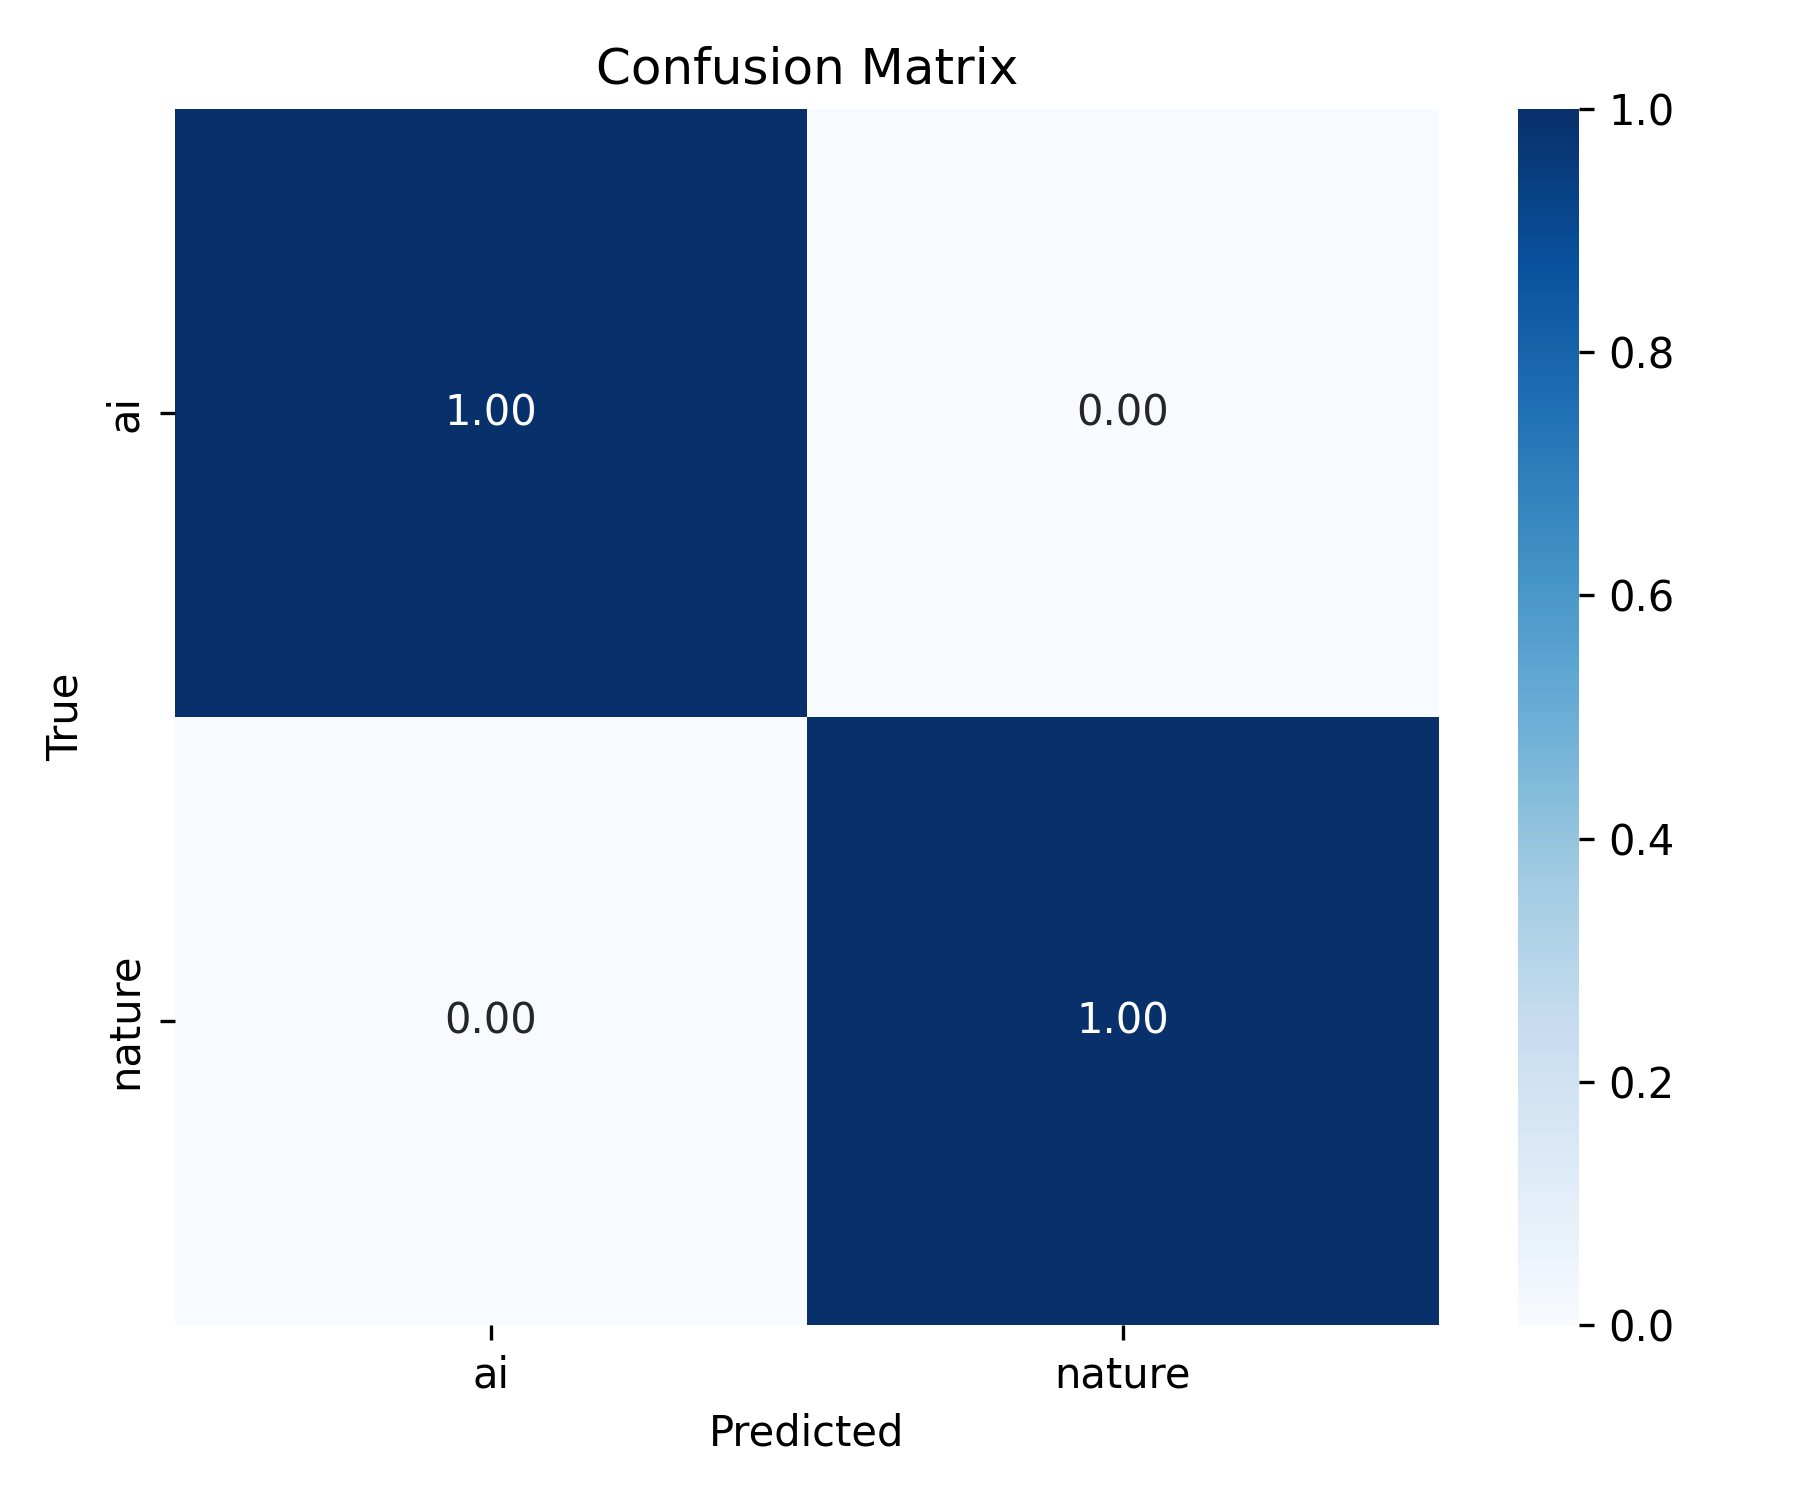

confusion_matrix_resnet18_vqdm_raw.png


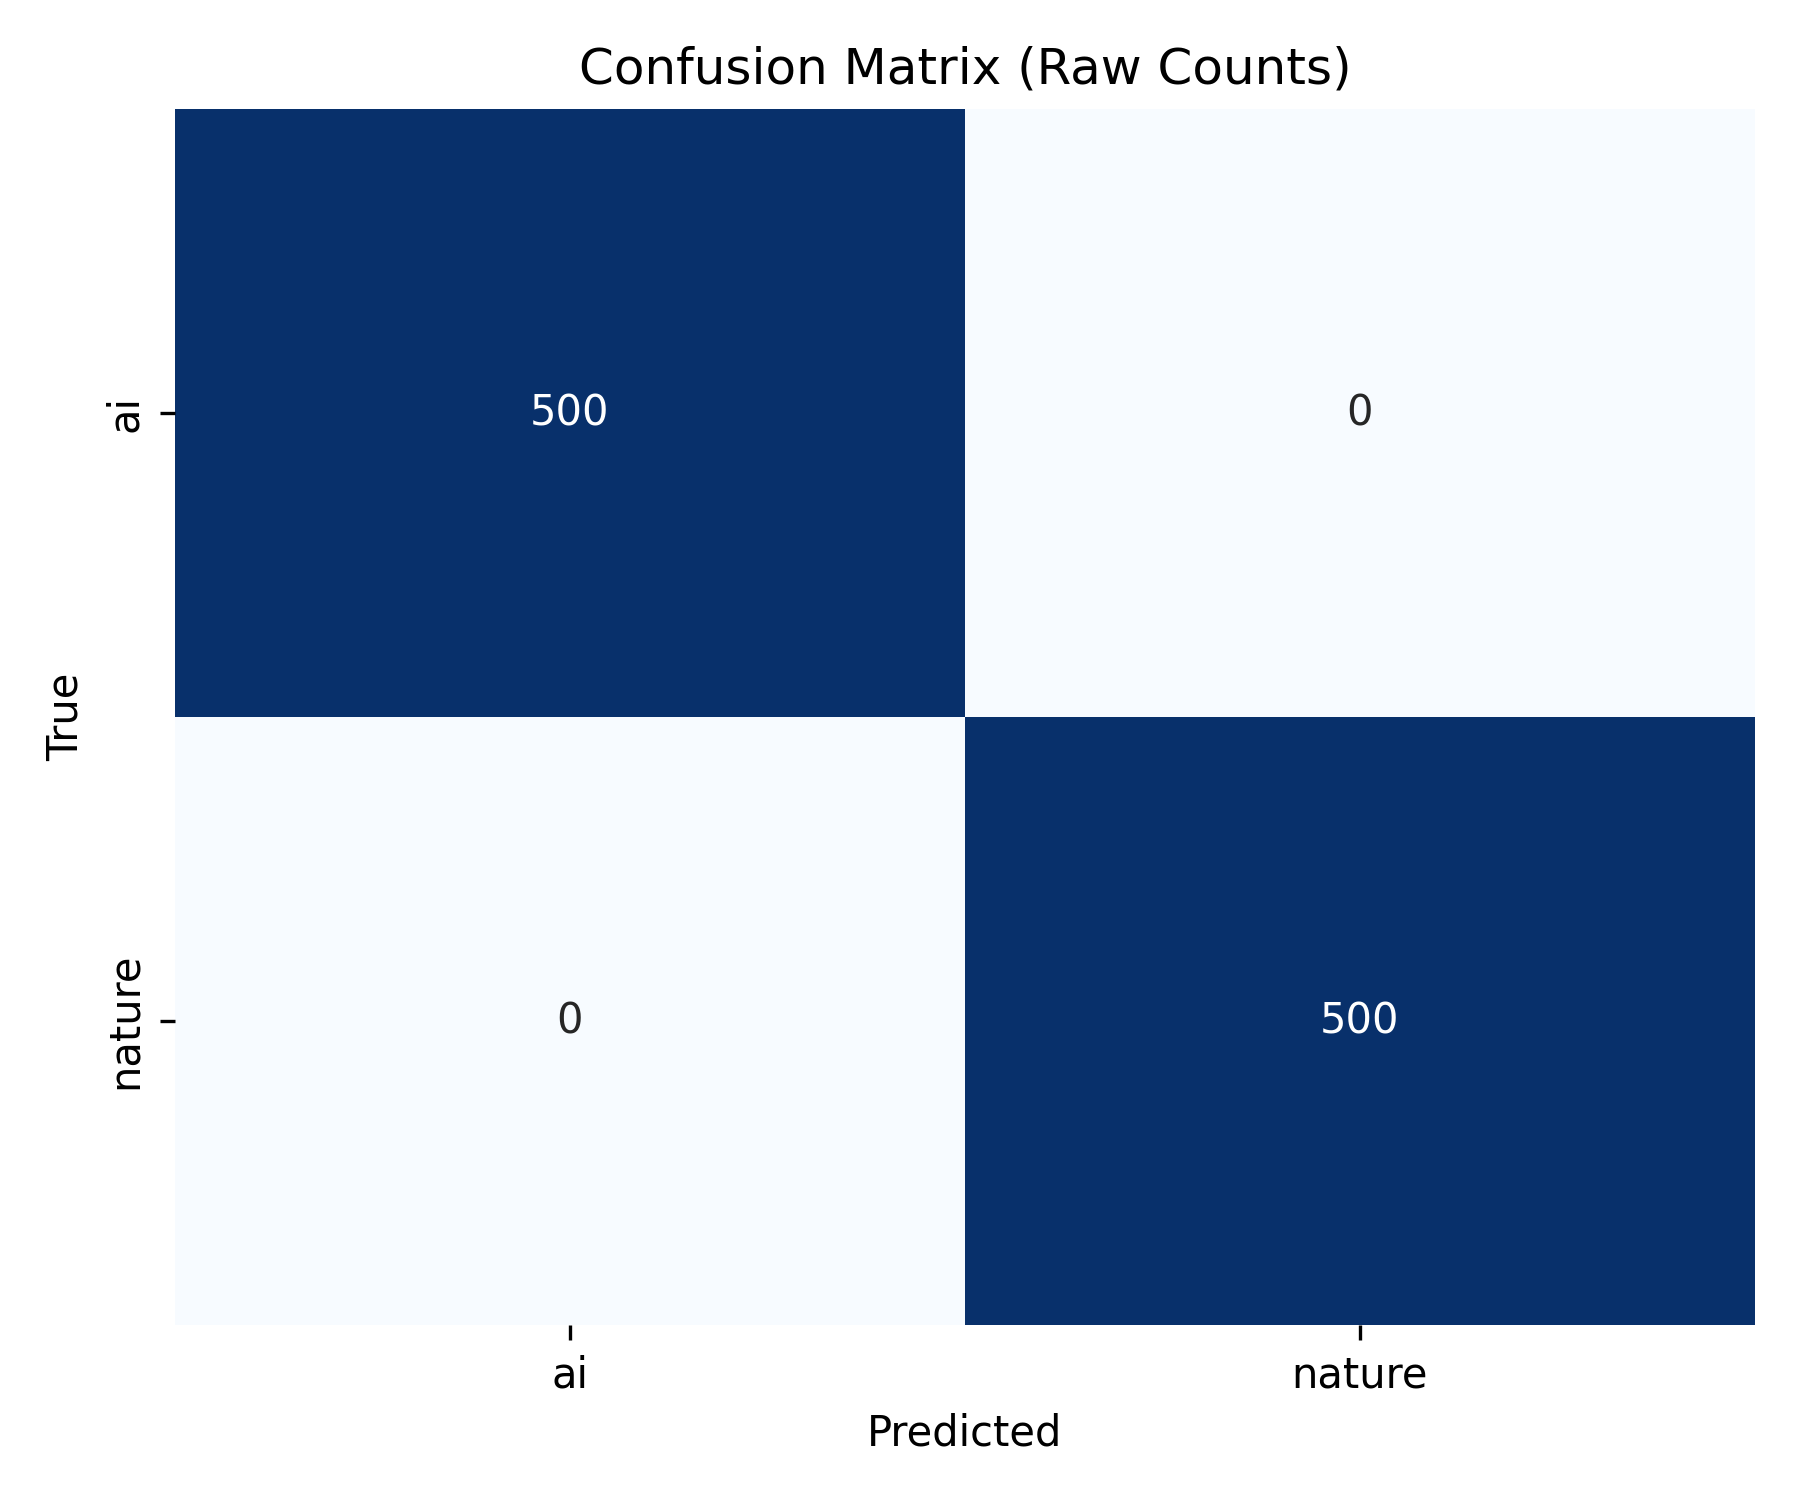

confusion_matrix_resnet18_wukong.png


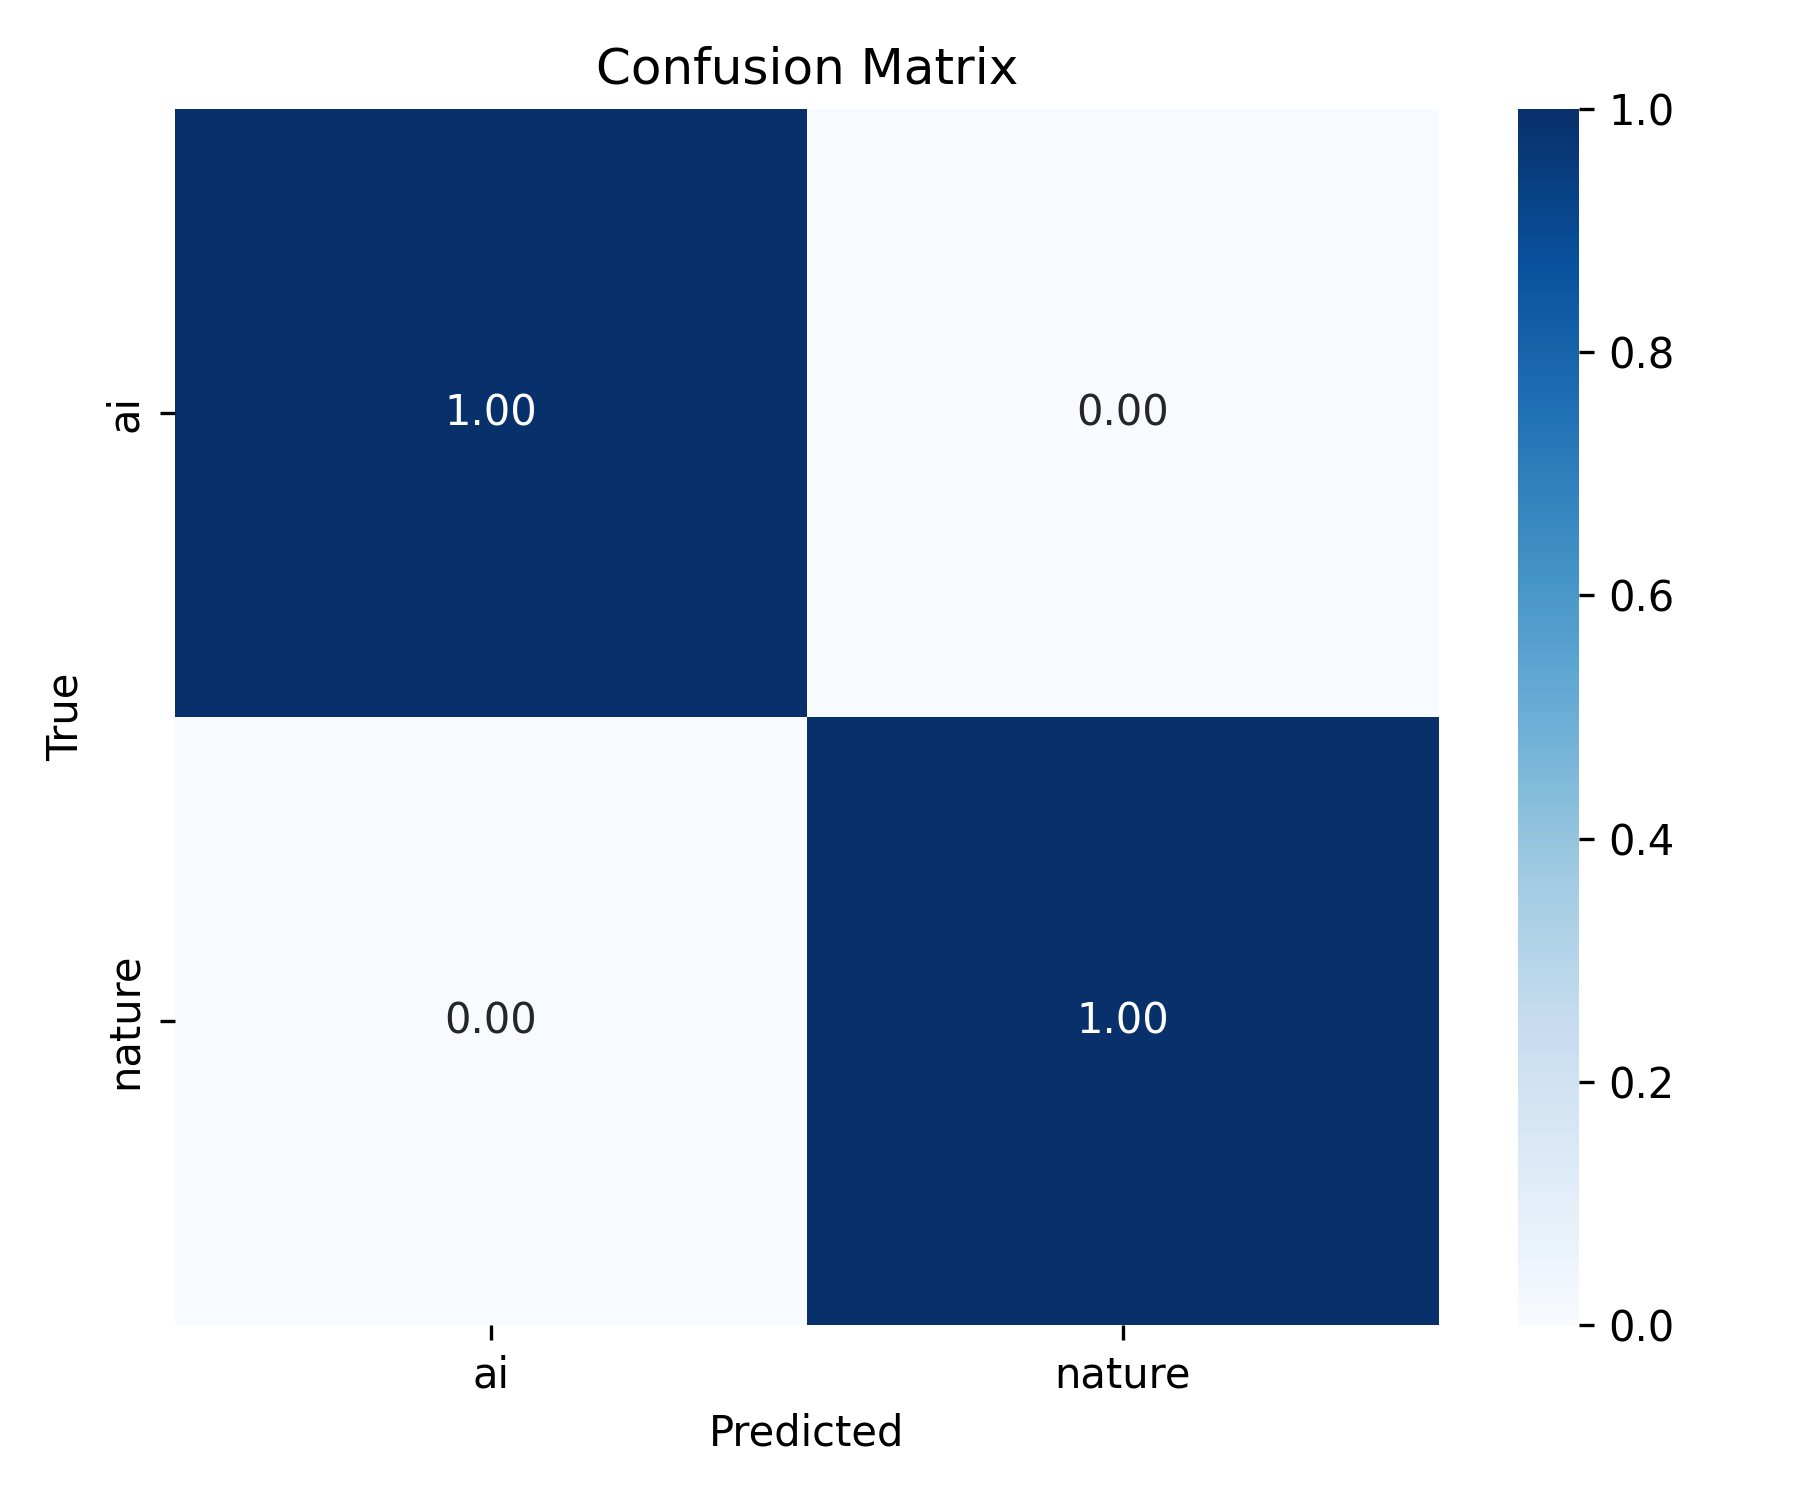

confusion_matrix_resnet18_wukong_raw.png


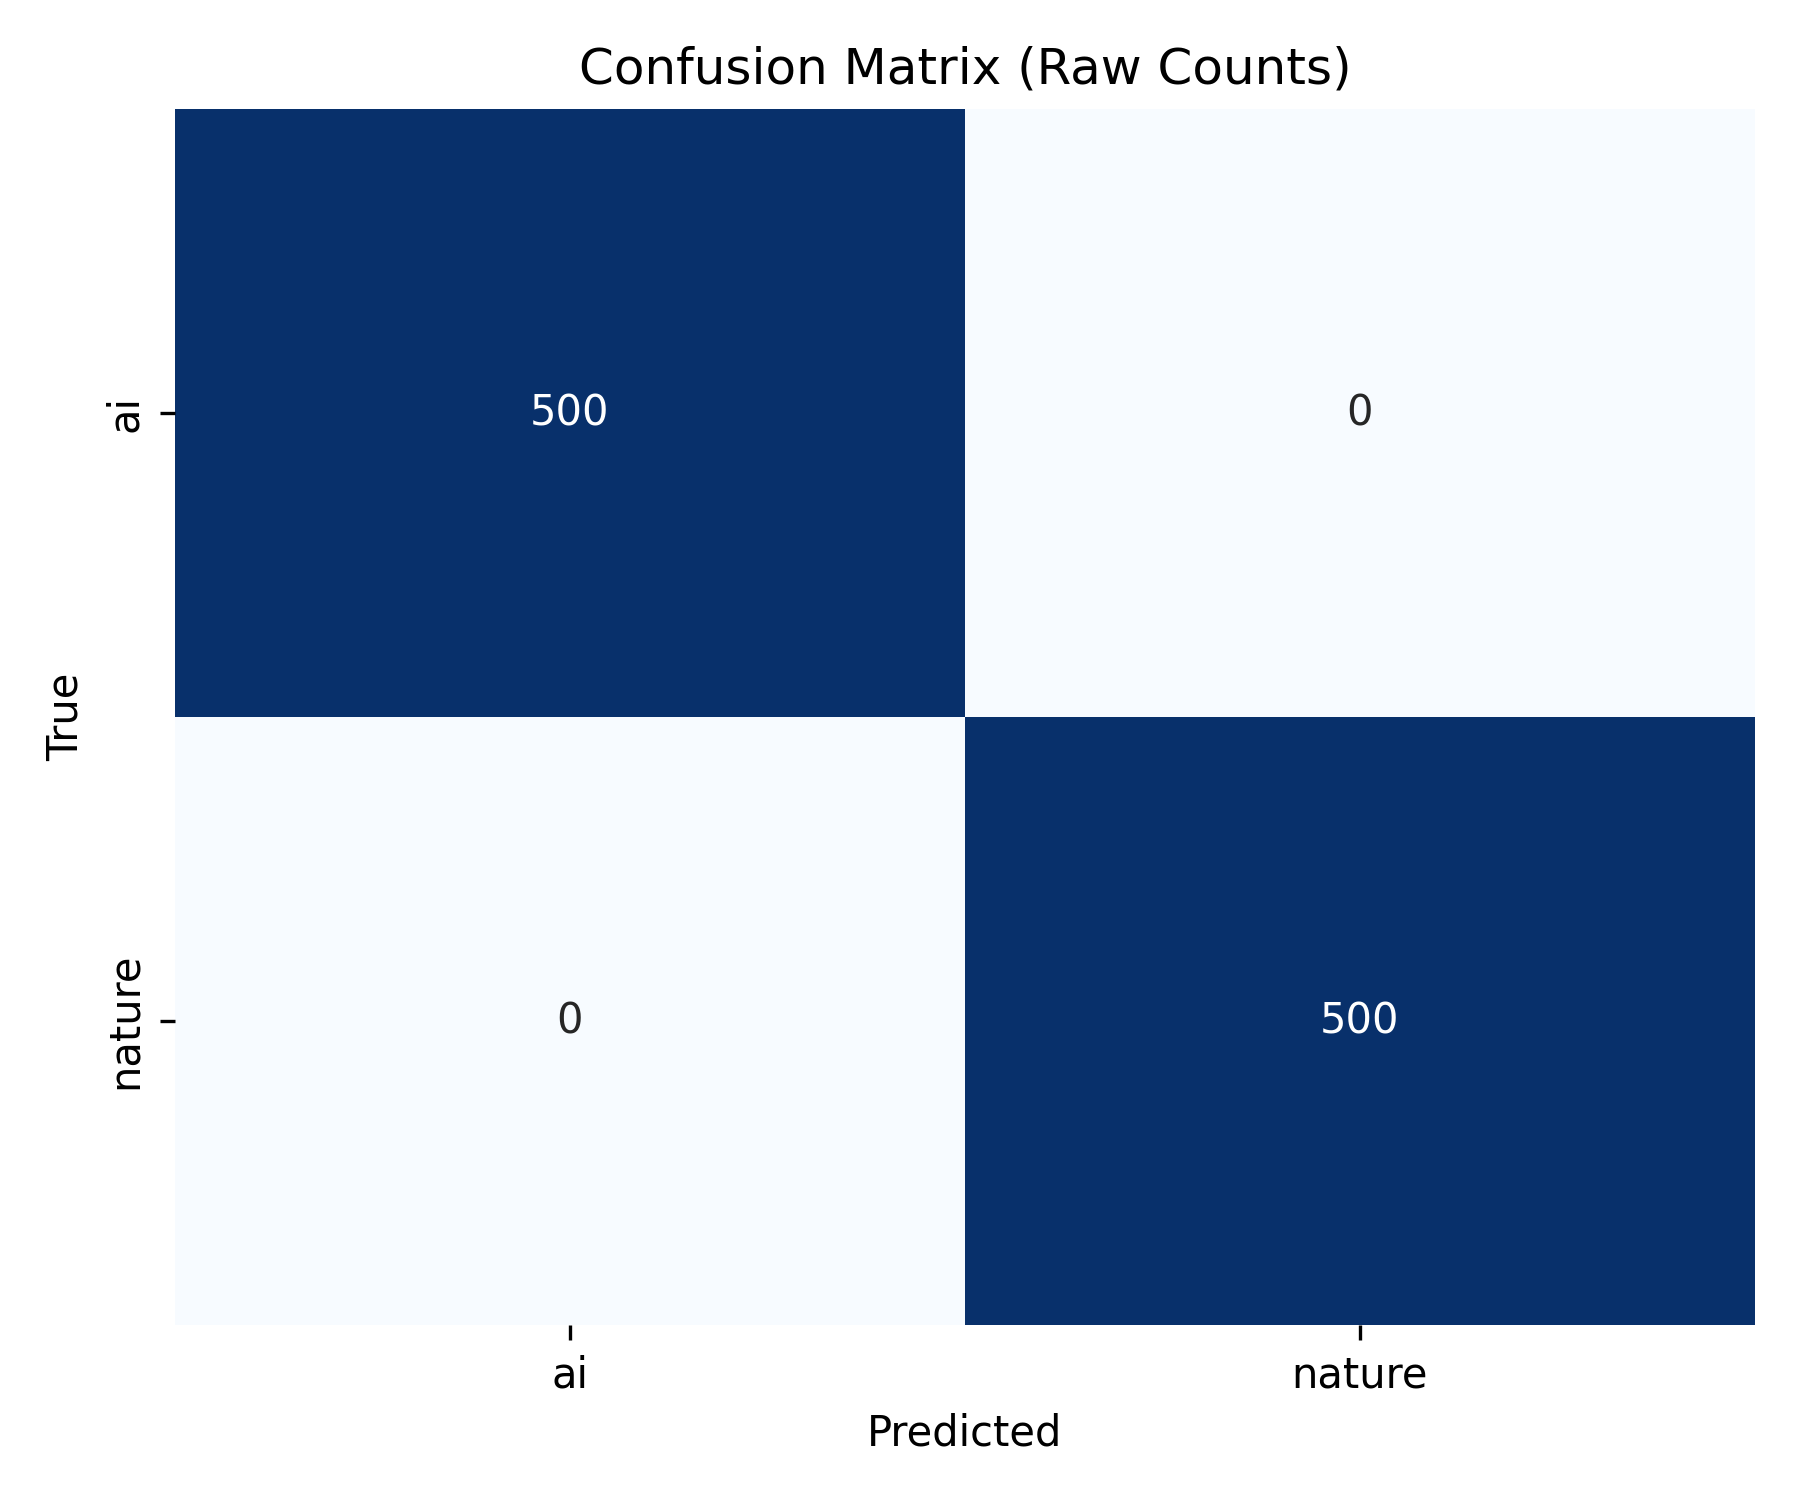

In [8]:
# 8. Confusion Matrices
cm_files = sorted(results_dir.glob("confusion_matrix_*.png"))
for cm_path in cm_files:
    print(cm_path.name)
    display(Image(filename=str(cm_path)))
if not cm_files:
    print("No confusion matrix images found in results/")

In [9]:
# 9. Summary Table
if not eval_df.empty:
    summary = eval_df.groupby("model")[["accuracy","precision","recall","f1"]].mean().sort_values("f1", ascending=False)
    display(summary)
else:
    print("No evaluation metrics to summarize.")

,accuracy,precision,recall,f1
model,,,,
resnet18,0.999286,0.998573,1.0,0.999286


In [10]:
# 10. Export Summary
if not eval_df.empty:
    out_dir = results_dir / "analysis_exports"
    out_dir.mkdir(parents=True, exist_ok=True)
    summary = eval_df.groupby("model")[["accuracy","precision","recall","f1"]].mean()
    summary.to_csv(out_dir / "final_metrics_summary.csv")
    print(f"Exported: {out_dir / 'final_metrics_summary.csv'}")

Exported: ../results/analysis_exports/final_metrics_summary.csv
